# CNN Waste Classification

## Data Pre-Processing

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
#!pip install torch -- uncomment first time you run
import seaborn as sns
#!pip install torch -- uncomment first time you run
import torch
#!pip install torchvision -- uncomment first time you run
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import ImageFolder

In [5]:
# Define set of transformations- convert image to PyTorch tensor, scale pixels from 0-255 to 0.0 - 1.0, normalizes pixels to -1.0 - 1.0
# Output is a (3, 256, 256) array --> Color channels 0.0 - 1.0 and the dimensions 256x256
transform_scratch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
# Load in the dataset and apply the transform
from torchvision.datasets import ImageFolder

full_dataset = ImageFolder(root="images/", transform=transform_scratch)
print(f"Total images: {len(full_dataset)}") # Print number of images
print(f"Class labels: {full_dataset.classes}") # Print all of the class labels

Total images: 15000
Class labels: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


## Define Data Splits

-- **NOTES** --

Here we can mess around with different training splits such as 
- Random split
- Evenly divide each sub-category (Stratified)
- Evenly divide each sub-category AND default/real world images (Double Stratified)
- Train more on default images, test more on real world (Studio Train)

All of these are implemented below. Maybe we start with either random or double stratified but can test out all going forward.

In [7]:
from torch.utils.data import random_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

import numpy as np

# Set the split sizes
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size) # TRAIN proportion = 0.7
val_size = int(0.15 * dataset_size) # VALIDATION proportion = 0.15
test_size = dataset_size - train_size - val_size  # TEST proportion = 0.15

##### RANDOMLY split the dataset #####
random_train_dataset, random_val_dataset, random_test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Random Train size: {len(random_train_dataset)}")
print(f"Random Validation size: {len(random_val_dataset)}")
print(f"Random Test size: {len(random_test_dataset)}\n")

##### STRATIFIED SPLIT (Evenly distribute each category between the train, val, test proportions) #####
## Get all targets from the dataset
targets = np.array(full_dataset.targets)

# 1st split: Separate 70% training data and 30% temp (which will become val + test)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(splitter.split(np.zeros(len(targets)), targets))

# Use class labels from the temp split to do a second stratified split (val and test)
temp_targets = targets[temp_idx]

# 2nd split: Split the 30% temp into 15% val and 15% test
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter2.split(np.zeros(len(temp_idx)), temp_targets))

# Since val/test indices refer to the temp set, map them back to the full dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create PyTorch Subset objects for each split, using the final indices
strat_train_dataset = Subset(full_dataset, train_idx)
strat_val_dataset = Subset(full_dataset, val_idx)
strat_test_dataset = Subset(full_dataset, test_idx)

# Print sizes again
print(f"Stratified Train size: {len(strat_train_dataset)}")
print(f"Stratified Validation size: {len(strat_val_dataset)}")
print(f"Stratified Test size: {len(strat_test_dataset)}\n")

##### DOUBLE STRATIFIED SPLIT (Evenly distribute each category and real world vs default between train/val/test) #####
# Step 1: Create a list of full file paths for all images
all_paths = [full_dataset.samples[i][0] for i in range(len(full_dataset))]

# Step 2: Create a combined stratification label for each image: e.g., "plastic_water_bottles__default"
combined_labels = []
for path in all_paths:
    # Example path: images/plastic_water_bottles/default/image1.png
    parts = path.split(os.sep)
    category = parts[-3]  # e.g., plastic_water_bottles
    subtype = parts[-2]   # e.g., default or real_world
    combined_label = f"{category}__{subtype}"
    combined_labels.append(combined_label)

combined_labels = np.array(combined_labels)

# Step 3: First split: 70% train, 30% temp (val + test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(split1.split(np.zeros(len(combined_labels)), combined_labels))

# Step 4: Second split: split temp into 50% val, 50% test (i.e., 15% each overall)
temp_labels = combined_labels[temp_idx]
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(split2.split(np.zeros(len(temp_labels)), temp_labels))

# Map relative val/test indices back to full dataset indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

# Step 5: Create PyTorch Subsets
double_strat_train_dataset = Subset(full_dataset, train_idx)
double_strat_val_dataset = Subset(full_dataset, val_idx)
double_strat_test_dataset = Subset(full_dataset, test_idx)

# Optional sanity check
print(f"Double Stratified Train size: {len(double_strat_train_dataset)}")
print(f"Double Stratified Validation size: {len(double_strat_val_dataset)}")
print(f"Double Stratified Test size: {len(double_strat_test_dataset)}\n")

##### DEFAULT v REAL WORLD TRAIN SPLIT (All default goes to train, real_world fills in remaining train, then val & test) #####
# Map: class index → class name (e.g., 0 → 'plastic_water_bottles')
# Map class index → class name (e.g., 0 → 'plastic_water_bottles')
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Split default and real_world
default_indices = []
realworld_indices = []

for i, (path, class_idx) in enumerate(full_dataset.samples):
    subtype = path.split(os.sep)[-2]  # 'default' or 'real_world'
    if subtype == "default":
        default_indices.append(i)
    elif subtype == "real_world":
        realworld_indices.append(i)

# Calculate dataset sizes
total_size = len(full_dataset)
target_train_size = int(0.7 * total_size)
target_val_size = int(0.15 * total_size)
target_test_size = total_size - target_train_size - target_val_size

# Use all default images in training set
train_idx = set(default_indices)

# How many more real_world images needed for train?
remaining_needed = target_train_size - len(train_idx)

# Sanity check
if remaining_needed < 0:
    raise ValueError("Too many default images to satisfy 70% train split!")

# Convert to array
realworld_indices = np.array(realworld_indices)

# First: get required real_world images for training
rw_train_idx, rw_temp_idx = train_test_split(
    realworld_indices,
    train_size=remaining_needed,
    random_state=42,
    shuffle=True
)

# Second: split the rest equally into val and test
rw_val_idx, rw_test_idx = train_test_split(
    rw_temp_idx,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

# Final index sets
train_idx.update(rw_train_idx)
val_idx = set(rw_val_idx)
test_idx = set(rw_test_idx)

# Create subsets
drw_train_dataset = Subset(full_dataset, sorted(train_idx))
drw_val_dataset = Subset(full_dataset, sorted(val_idx))
drw_test_dataset = Subset(full_dataset, sorted(test_idx))

# Print final sizes
print(f"DRW Train size: {len(drw_train_dataset)}")
print(f"DRW Validation size: {len(drw_val_dataset)}")
print(f"DRW Test size: {len(drw_test_dataset)}")

Random Train size: 10500
Random Validation size: 2250
Random Test size: 2250

Stratified Train size: 10500
Stratified Validation size: 2250
Stratified Test size: 2250

Double Stratified Train size: 10500
Double Stratified Validation size: 2250
Double Stratified Test size: 2250

DRW Train size: 10500
DRW Validation size: 2250
DRW Test size: 2250


### Implement Data Loader

In [8]:
from torch.utils.data import DataLoader

# Use data loader to improve efficiency of loading data during training
batch_size = 32  # Can be adjusted

# shuffle = True : Ensures all images from a category aren't trained on consecutively
random_train_loader = DataLoader(random_train_dataset, batch_size=batch_size, shuffle=True) 
random_val_loader = DataLoader(random_val_dataset, batch_size=batch_size, shuffle=False)
random_test_loader = DataLoader(random_test_dataset, batch_size=batch_size, shuffle=False)


double_strat_train_loader = DataLoader(double_strat_train_dataset, batch_size=batch_size, shuffle=True) 
double_strat_train_loader = DataLoader(double_strat_val_dataset, batch_size=batch_size, shuffle=False)
double_strat_train_loader = DataLoader(double_strat_test_dataset, batch_size=batch_size, shuffle=False)


# Testing Basic CNNs

### (1) TRAINING: random train/test split used, lr = .001, no overfitting methods used, 5 epochs, target 30 categories 

### (1) MODEL: 3 conv+pool layers, max pool 2x2 (halves image size) from 256 --> 128 --> 64 --> 32, 2 fully connected layers, fc1 input=131,072 output=256, fc2 input=256, output=30, RELU, kernel size = 3x3 (SAME for all in this section)

In [14]:
# ----------------------
# IMPORTS
# ----------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------
# DEVICE SETUP
# ----------------------
# Automatically selects GPU if available, otherwise uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# MODEL DEFINITION
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        # Convolutional layers to learn spatial features
        super(WasteClassifierCNN, self).__init__()
        #Format is (Channels In, Channels Out, Size of Filter, Padding)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Input: RGB (3 channels)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Max pooling layer to reduce spatial resolution
        self.pool = nn.MaxPool2d(2, 2) # Halves width and height each time

        # After 3 poolings: 256x256 → 128 → 64 → 32 ⇒ final feature map: [128 x 32 x 32]
        self.flattened_size = 128 * 32 * 32 # Total number of features before FC layers

        # Fully connected layers to classify based on extracted features
        self.fc1 = nn.Linear(self.flattened_size, 256) # Hidden layer
        self.fc2 = nn.Linear(256, num_classes) # Output layer

    def forward(self, x):
        # Apply convolutions, activation, and pooling in sequence
        x = self.pool(F.relu(self.conv1(x))) # Output: [B, 32, 128, 128] --> (Batch Size, Channels, Height, Width)
        x = self.pool(F.relu(self.conv2(x))) # Output: [B, 64, 64, 64]
        x = self.pool(F.relu(self.conv3(x))) # Output: [B, 128, 32, 32]

        # Flatten the feature maps into a 1D vector
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x)) # Hidden representation
        x = self.fc2(x) # Final classification logits
        return x

# ----------------------
# MODEL INITIALIZATION
# ----------------------
num_classes = len(full_dataset.classes) # Automatically get number of classes
model = WasteClassifierCNN(num_classes=num_classes).to(device) # Move Model to CPU

# ----------------------
# LOSS FUNCTION & OPTIMIZER
# ----------------------
criterion = nn.CrossEntropyLoss() # Loss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adaptive optimizer

# ----------------------
# TRAINING LOOP WITH VALIDATION TRACKING
# ----------------------
num_epochs = 5 # Number of full passes through the training data

# DataLoaders using random split
train_loader = random_train_loader
val_loader = random_val_loader  

# Dictionary to keep track of losses for plotting
history = {
    "loss": [],
    "val_loss": []
}

# Loop over each epoch
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0  # Track correct predictions
    total = 0  # Track total predictions

    print(f"\nEpoch {epoch+1}/{num_epochs}")  #Nicely formatted print statement

    # Loop over training batches with progress bar
    loop = tqdm(train_loader, total=len(train_loader), leave=True, ncols=100)

    for images, labels in loop:

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar with running accuracy and loss
        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

     # Average loss over all batches for this epoch
    avg_train_loss = running_loss / len(train_loader)
    history["loss"].append(avg_train_loss)

    # ----------------------
    # VALIDATION STEP
    # ----------------------

    # Set model to evaluation mode
    model.eval()
    val_loss = 0.0

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Average validation loss across all batches
    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)

     # Print both losses side-by-side for review
    print(f"→ Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

Using device: cpu

Epoch 1/5


100%|████████████████████████████████████| 329/329 [04:45<00:00,  1.15it/s, acc=0.2290, loss=2.7763]


→ Training Loss: 2.7763 | Validation Loss: 2.2617

Epoch 2/5


100%|████████████████████████████████████| 329/329 [04:55<00:00,  1.11it/s, acc=0.4850, loss=1.8398]


→ Training Loss: 1.8398 | Validation Loss: 1.9563

Epoch 3/5


100%|████████████████████████████████████| 329/329 [05:08<00:00,  1.07it/s, acc=0.6719, loss=1.1710]


→ Training Loss: 1.1710 | Validation Loss: 1.8070

Epoch 4/5


100%|████████████████████████████████████| 329/329 [05:10<00:00,  1.06it/s, acc=0.8141, loss=0.6292]


→ Training Loss: 0.6292 | Validation Loss: 1.9434

Epoch 5/5


100%|████████████████████████████████████| 329/329 [05:12<00:00,  1.05it/s, acc=0.9047, loss=0.3208]


→ Training Loss: 0.3208 | Validation Loss: 2.1914


### Check for Overfitting

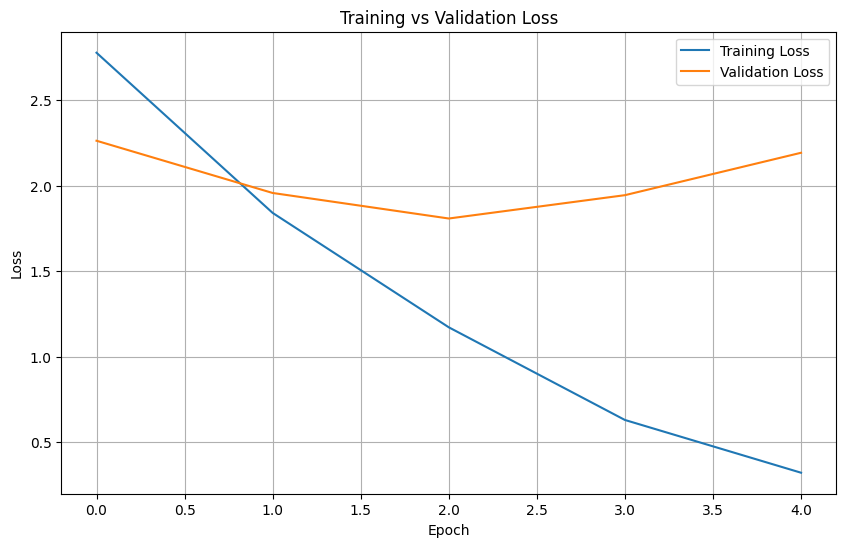

In [15]:
# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Construct a Confusion Matrix

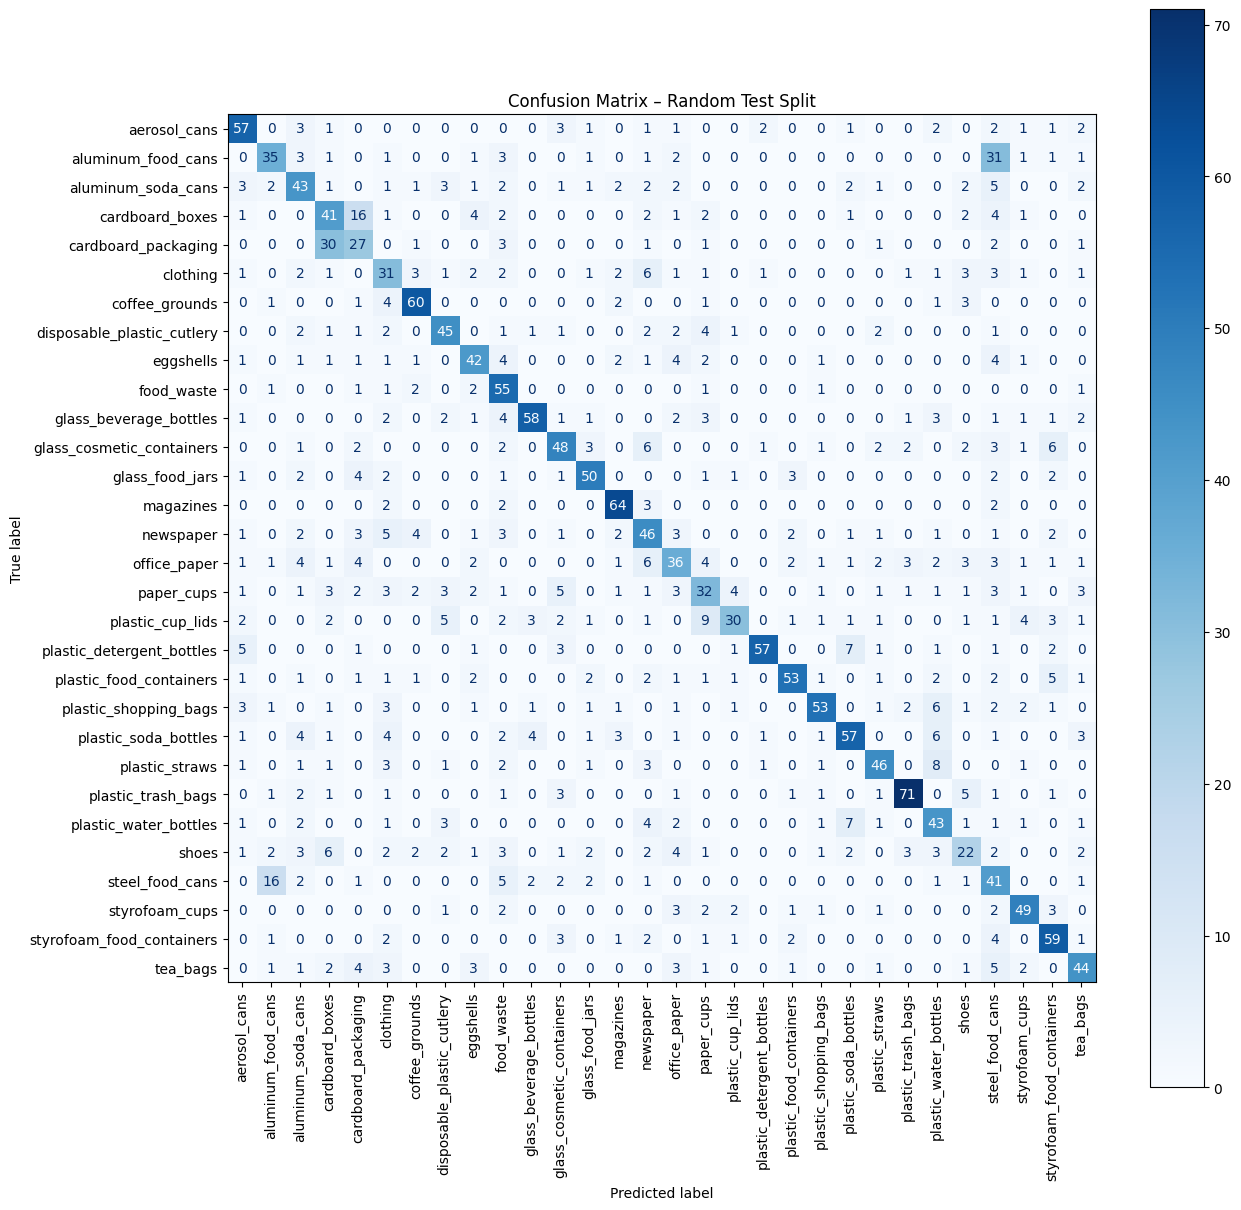

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set the model to evaluation mode (disables dropout/batchnorm behavior)
model.eval()

# Lists to store predicted and true labels
all_preds = []
all_labels = []

# Disable gradient calculation for inference (faster and uses less memory)
with torch.no_grad():
    # Loop through the test data loader from the random split
    for images, labels in random_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
         # Perform a forward pass through the model to get predictions
        outputs = model(images)
        
        # Get the predicted class with the highest probability
        _, predicted = torch.max(outputs, 1)

        # Store predictions and true labels (move them to CPU and convert to numpy)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix based on all test predictions vs actual labels
cm = confusion_matrix(all_labels, all_preds)

# Create a confusion matrix display (labelled with class names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

# Plot
fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – Random Test Split")
plt.show()


### Check Accuracy by Category

In [17]:
# Initialize lists
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    
    # Loop through batches in the test set
    for images, labels in random_test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass to get model predictions
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1) # Get class index with the highest logit for each image

        # Compare predictions with true labels for each item in the batch
        for label, prediction in zip(labels, predicted):
            class_total[label] += 1
            if label == prediction:
                class_correct[label] += 1

print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-"*40)
for i, class_name in enumerate(full_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 73.08%
aluminum_food_cans             — Accuracy: 42.68%
aluminum_soda_cans             — Accuracy: 55.84%
cardboard_boxes                — Accuracy: 52.56%
cardboard_packaging            — Accuracy: 40.30%
clothing                       — Accuracy: 47.69%
coffee_grounds                 — Accuracy: 82.19%
disposable_plastic_cutlery     — Accuracy: 68.18%
eggshells                      — Accuracy: 62.69%
food_waste                     — Accuracy: 84.62%
glass_beverage_bottles         — Accuracy: 69.05%
glass_cosmetic_containers      — Accuracy: 60.00%
glass_food_jars                — Accuracy: 71.43%
magazines                      — Accuracy: 87.67%
newspaper                      — Accuracy: 58.23%
office_paper                   — Accuracy: 45.00%
paper_cups                     — Accuracy: 42.11%
plastic_cup_lids               — Accuracy: 42.25%
plastic_detergent_bottles 

### Total Accuracy

In [18]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy: {overall_acc:.2f}%")


✅ Overall Test Accuracy: 62.00%


## Model 2: Same Model, Implement Early Stopping, L2 Regularization and Dropout. Train for 10 epochs

In [21]:
##ANTI-OVERFITTING

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model with Dropout
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(p=0.5) # Randomly zeroes 50% of neurons during training
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Applies dropout during training only
        x = self.fc2(x)
        return x

# Initialize model
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes).to(device)

# Loss & Optimizer with L2 regularization (weight_decay)
criterion = nn.CrossEntropyLoss()

# L2 regularization is implemented by setting weight_decay
# Helps penalize large weights to reduce overfitting (larger means greater penalty for higher weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Loaders
train_loader = random_train_loader
val_loader = random_val_loader

# Training with Early Stopping
num_epochs = 10
patience = 2
best_val_loss = float('inf')
patience_counter = 0

history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    # Record training loss
    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss # Update best loss
        patience_counter = 0 # Reset counter if improvement
        torch.save(model.state_dict(), "best_model.pt") # Save model checkpoint
    else: 
        patience_counter += 1 # No improvement → increase patience counter
        if patience_counter >= patience: # Stop training if patience exhausted
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Using device: cpu


Epoch 1 | Train Loss: 3.0239 | Val Loss: 2.5852


Epoch 2 | Train Loss: 2.5098 | Val Loss: 2.1863


Epoch 3 | Train Loss: 2.0506 | Val Loss: 1.9217


Epoch 4 | Train Loss: 1.6288 | Val Loss: 1.6435


Epoch 5 | Train Loss: 1.2602 | Val Loss: 1.5913


Epoch 6 | Train Loss: 0.9710 | Val Loss: 1.5255


Epoch 7 | Train Loss: 0.7387 | Val Loss: 1.5872


Epoch 8 | Train Loss: 0.6368 | Val Loss: 1.6195
Early stopping triggered after 8 epochs.


### Training vs Validation Plot

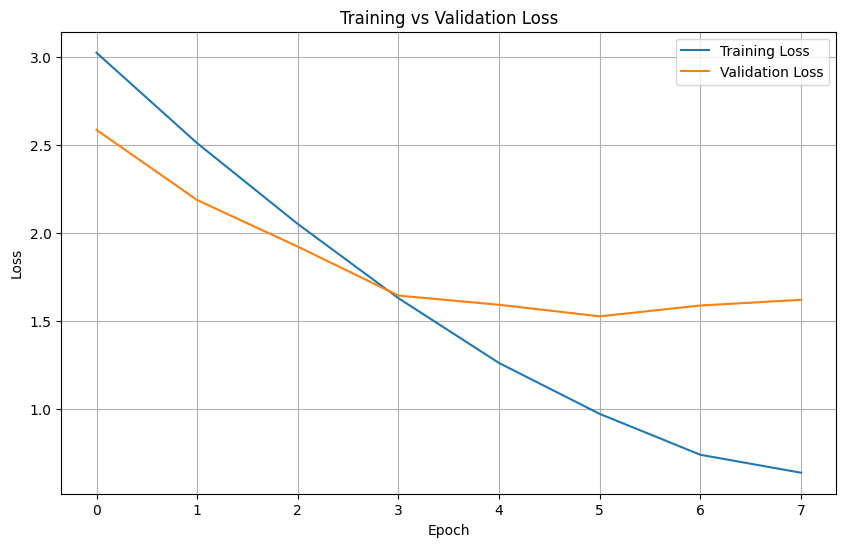

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Confusion Matrix for Model 2

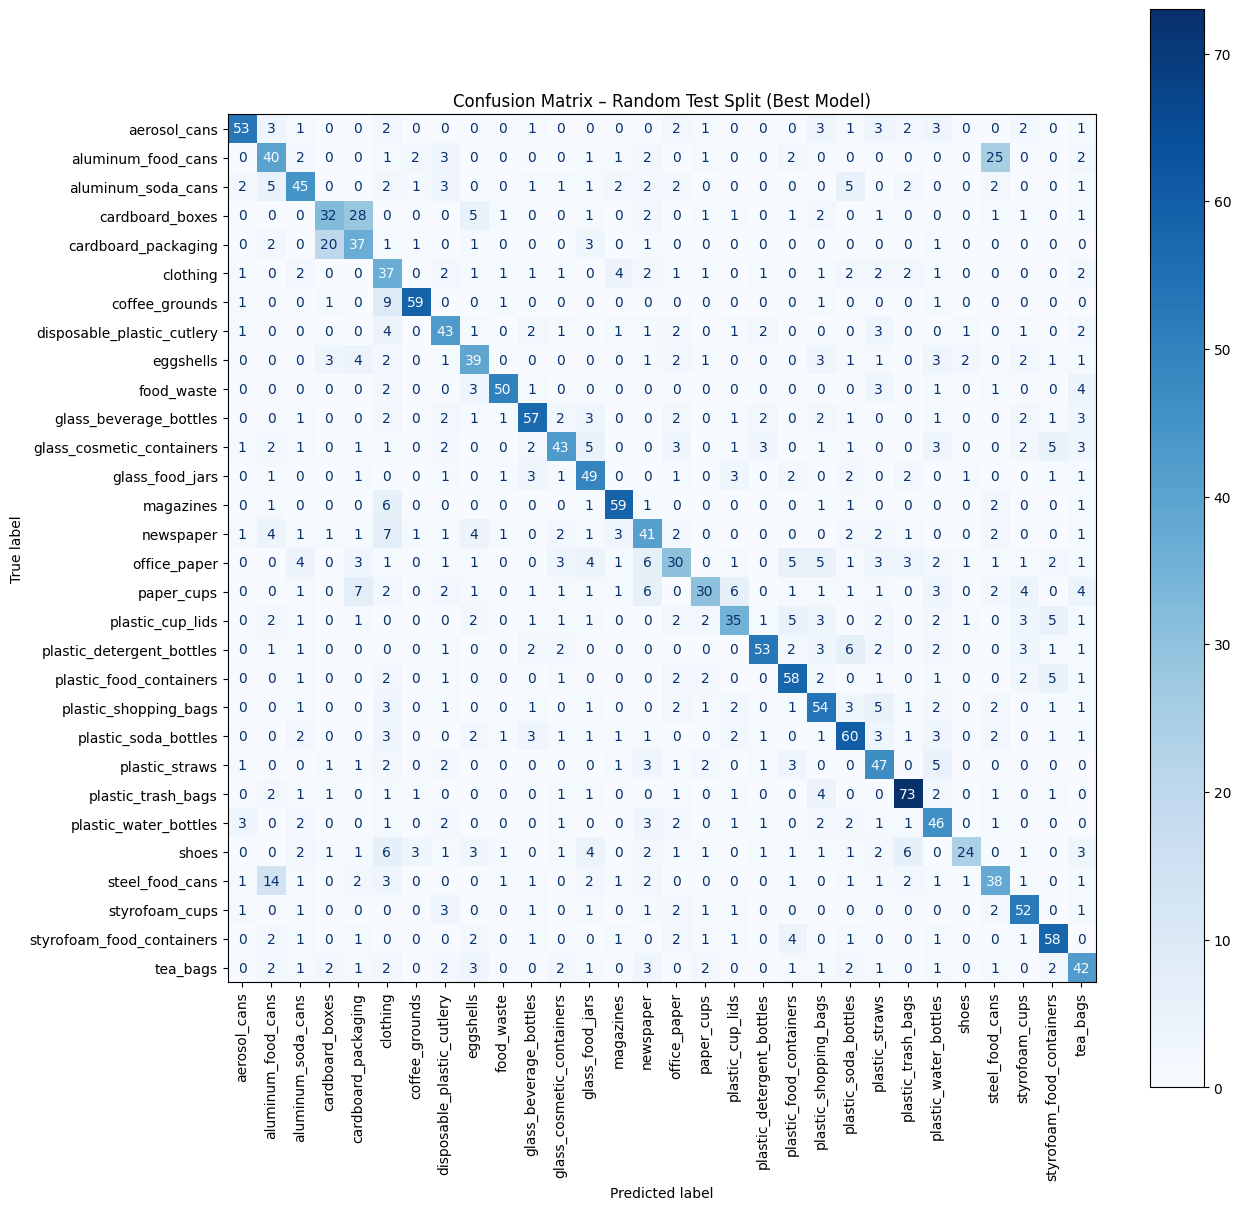

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Load best model weights from early stopping
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds = []
all_labels = []

# ✅ Use the random test split to match the training and validation splits
with torch.no_grad():
    for images, labels in random_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – Random Test Split (Best Model)")
plt.show()


### Accuracy by Category for Model 2

In [24]:
# Load best model weights from early stopping
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Initialize counters
class_correct = [0] * num_classes
class_total = [0] * num_classes

# Evaluate per-class accuracy
with torch.no_grad():
    for images, labels in random_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for label, prediction in zip(labels, predicted):
            class_total[label.item()] += 1
            if label == prediction:
                class_correct[label.item()] += 1

# Print per-class accuracy
print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-"*40)
for i, class_name in enumerate(full_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 67.95%
aluminum_food_cans             — Accuracy: 48.78%
aluminum_soda_cans             — Accuracy: 58.44%
cardboard_boxes                — Accuracy: 41.03%
cardboard_packaging            — Accuracy: 55.22%
clothing                       — Accuracy: 56.92%
coffee_grounds                 — Accuracy: 80.82%
disposable_plastic_cutlery     — Accuracy: 65.15%
eggshells                      — Accuracy: 58.21%
food_waste                     — Accuracy: 76.92%
glass_beverage_bottles         — Accuracy: 67.86%
glass_cosmetic_containers      — Accuracy: 53.75%
glass_food_jars                — Accuracy: 70.00%
magazines                      — Accuracy: 80.82%
newspaper                      — Accuracy: 51.90%
office_paper                   — Accuracy: 37.50%
paper_cups                     — Accuracy: 39.47%
plastic_cup_lids               — Accuracy: 49.30%
plastic_detergent_bottles 

### Total Accuracy for Model 2

In [25]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy: {overall_acc:.2f}%")



✅ Overall Test Accuracy: 61.51%


## TRAINING for MODEL 3: SAME as above except using double stratified data split

### MODEL: SAME as above

In [26]:
# ----------------------
# IMPORTS
# ----------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# MODEL DEFINITION (with dropout)
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.5)  # Dropout added to reduce overfitting

        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ----------------------
# MODEL INITIALIZATION
# ----------------------
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes=num_classes).to(device)

# ----------------------
# DATA LOADERS (Double Stratified)
# ----------------------
batch_size = 32
train_loader = DataLoader(double_strat_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(double_strat_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(double_strat_test_dataset, batch_size=batch_size, shuffle=False)

# ----------------------
# LOSS FUNCTION & OPTIMIZER (with L2 regularization)
# ----------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# ----------------------
# TRAINING LOOP with Early Stopping & Validation
# ----------------------
num_epochs = 10
patience = 2
best_val_loss = float("inf")
epochs_without_improvement = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    loop = tqdm(train_loader, total=len(train_loader), leave=True, ncols=100)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    # Average training loss
    avg_train_loss = running_loss / len(train_loader)
    history["loss"].append(avg_train_loss)

    # ----------------------
    # VALIDATION PHASE
    # ----------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)

    print(f"🔍 Validation Loss: {avg_val_loss:.4f}")

    # ----------------------
    # EARLY STOPPING LOGIC
    # ----------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model_double_strat.pt")  # Save best model
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("⏹️ Early stopping triggered.")
            break

Using device: cpu

Epoch 1/10


100%|████████████████████████████████████| 329/329 [04:46<00:00,  1.15it/s, acc=0.1275, loss=3.1648]


🔍 Validation Loss: 2.6945

Epoch 2/10


100%|████████████████████████████████████| 329/329 [04:49<00:00,  1.13it/s, acc=0.3147, loss=2.4747]


🔍 Validation Loss: 2.1525

Epoch 3/10


100%|████████████████████████████████████| 329/329 [04:50<00:00,  1.13it/s, acc=0.4597, loss=1.9175]


🔍 Validation Loss: 1.8329

Epoch 4/10


100%|████████████████████████████████████| 329/329 [04:49<00:00,  1.14it/s, acc=0.5923, loss=1.4098]


🔍 Validation Loss: 1.6081

Epoch 5/10


100%|████████████████████████████████████| 329/329 [04:49<00:00,  1.14it/s, acc=0.7002, loss=1.0143]


🔍 Validation Loss: 1.6088

Epoch 6/10


100%|████████████████████████████████████| 329/329 [04:53<00:00,  1.12it/s, acc=0.7603, loss=0.7989]


🔍 Validation Loss: 1.5754

Epoch 7/10


100%|████████████████████████████████████| 329/329 [04:49<00:00,  1.14it/s, acc=0.8152, loss=0.6025]


🔍 Validation Loss: 1.7321

Epoch 8/10


100%|████████████████████████████████████| 329/329 [04:50<00:00,  1.13it/s, acc=0.8487, loss=0.4944]


🔍 Validation Loss: 1.7608
⏹️ Early stopping triggered.


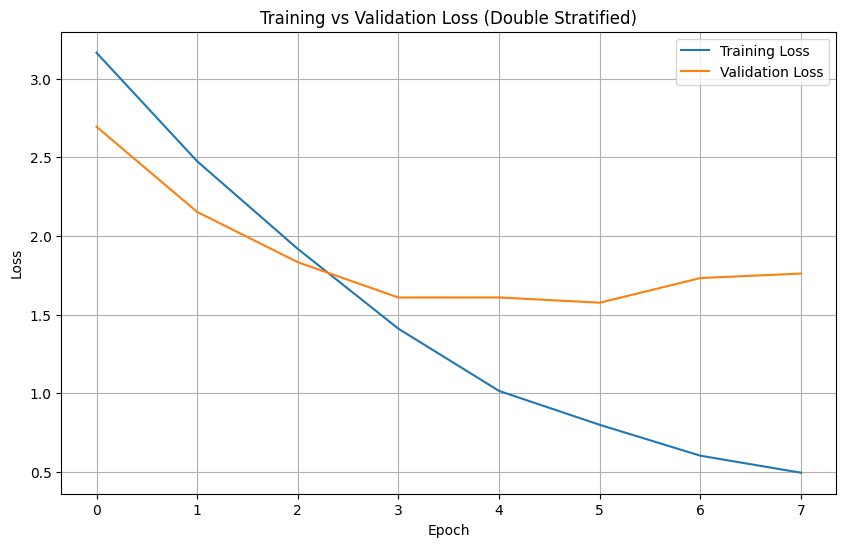

In [27]:
# ----------------------
# PLOT TRAINING vs VALIDATION LOSS
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Double Stratified)")
plt.legend()
plt.grid(True)
plt.show()


### Confusion Matrix for Model 3

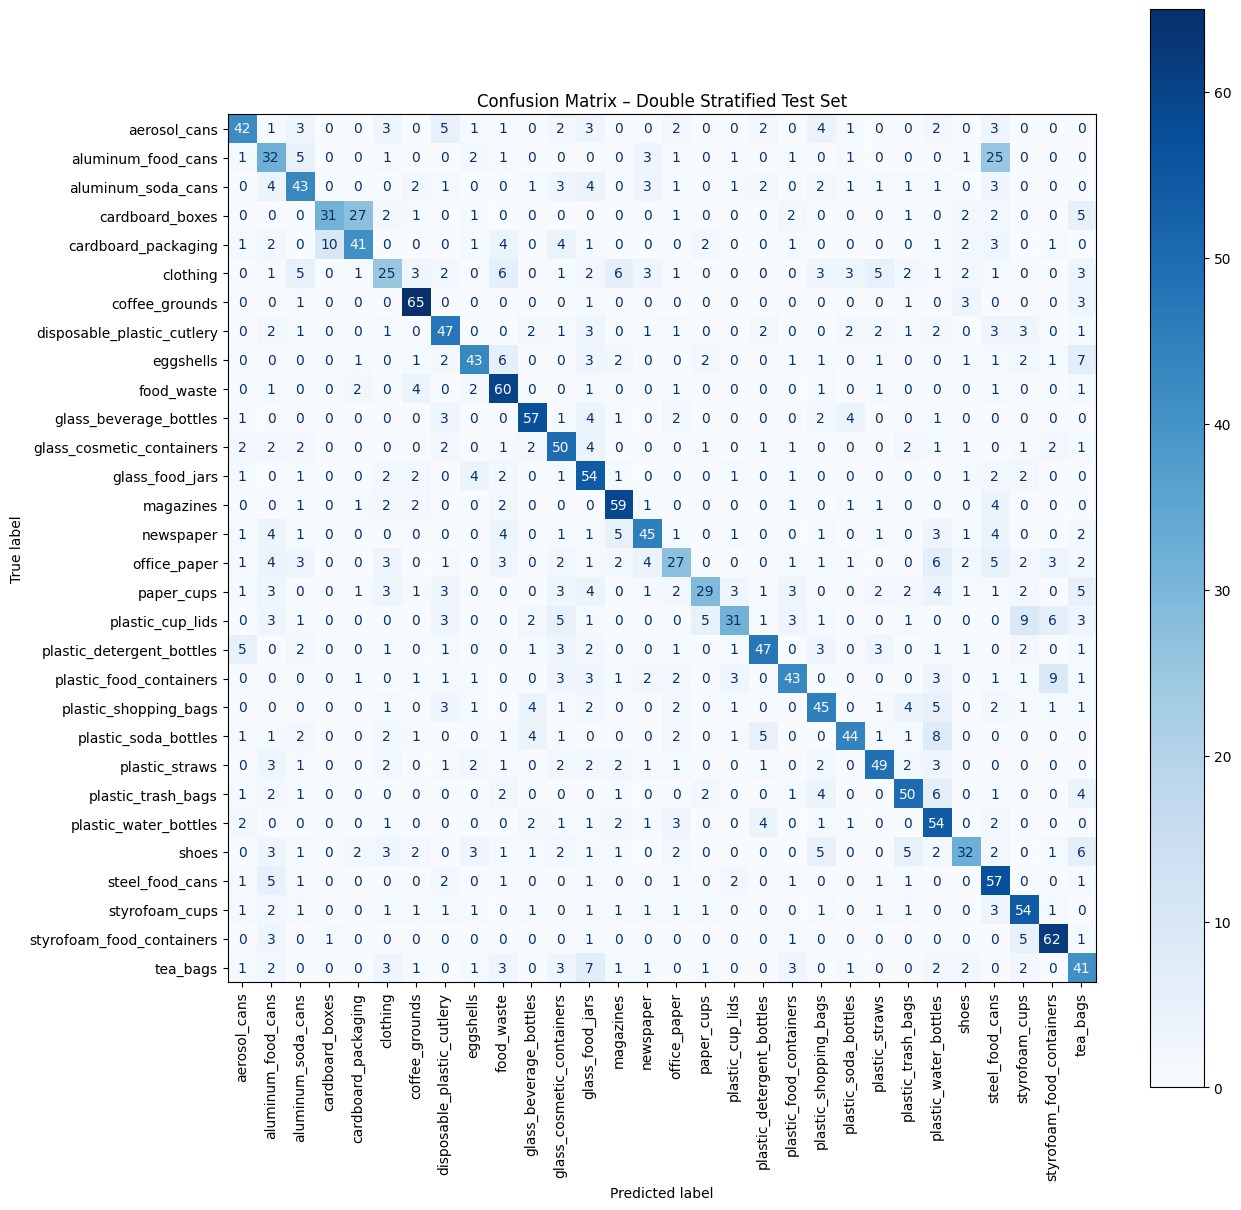

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Load best saved model (from early stopping)
model.load_state_dict(torch.load("best_model_double_strat.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # Uses double_strat_test_dataset
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – Double Stratified Test Set")
plt.show()


### Accuracy by Category for Model 3

In [29]:
# Reuse same model with best weights from training
model.load_state_dict(torch.load("best_model_double_strat.pt"))
model.eval()

class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for label, prediction in zip(labels, predicted):
            class_total[label] += 1
            if label == prediction:
                class_correct[label] += 1

print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-"*40)
for i, class_name in enumerate(full_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 56.00%
aluminum_food_cans             — Accuracy: 42.67%
aluminum_soda_cans             — Accuracy: 58.11%
cardboard_boxes                — Accuracy: 41.33%
cardboard_packaging            — Accuracy: 55.41%
clothing                       — Accuracy: 32.89%
coffee_grounds                 — Accuracy: 87.84%
disposable_plastic_cutlery     — Accuracy: 62.67%
eggshells                      — Accuracy: 57.33%
food_waste                     — Accuracy: 80.00%
glass_beverage_bottles         — Accuracy: 75.00%
glass_cosmetic_containers      — Accuracy: 65.79%
glass_food_jars                — Accuracy: 72.00%
magazines                      — Accuracy: 78.67%
newspaper                      — Accuracy: 59.21%
office_paper                   — Accuracy: 36.49%
paper_cups                     — Accuracy: 38.67%
plastic_cup_lids               — Accuracy: 41.33%
plastic_detergent_bottles 

### Total Accuracy for Model 3

In [30]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy: {overall_acc:.2f}%")


✅ Overall Test Accuracy: 60.40%


## Model 4: SAME as above but use DvRW data split

In [31]:
# ----------------------
# IMPORTS, DEVICE, MODEL, LOADER, TRAINING W/ EARLY STOPPING
# ----------------------

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model definition with dropout
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Init model
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes=num_classes).to(device)

# Loaders (Default vs Real World)
batch_size = 32
drw_train_loader = DataLoader(drw_train_dataset, batch_size=batch_size, shuffle=True)
drw_val_loader = DataLoader(drw_val_dataset, batch_size=batch_size, shuffle=False)
drw_test_loader = DataLoader(drw_test_dataset, batch_size=batch_size, shuffle=False)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Training loop with early stopping
num_epochs = 30
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(drw_train_loader, total=len(drw_train_loader), leave=True, ncols=100)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix({"acc": f"{(correct / total):.4f}", "loss": f"{running_loss / (loop.n + 1):.4f}"})

    train_loss = running_loss / len(drw_train_loader)
    history["loss"].append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in drw_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(drw_val_loader)
    history["val_loss"].append(val_loss)

    print(f"Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_drw.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Using device: cpu


100%|████████████████████████████████████| 329/329 [04:43<00:00,  1.16it/s, acc=0.1743, loss=2.9758]


Validation Loss: 2.6172


100%|████████████████████████████████████| 329/329 [04:45<00:00,  1.15it/s, acc=0.3674, loss=2.2459]


Validation Loss: 2.2069


100%|████████████████████████████████████| 329/329 [04:50<00:00,  1.13it/s, acc=0.5386, loss=1.6215]


Validation Loss: 1.8604


100%|████████████████████████████████████| 329/329 [04:52<00:00,  1.13it/s, acc=0.6636, loss=1.1306]


Validation Loss: 1.7003


100%|████████████████████████████████████| 329/329 [04:48<00:00,  1.14it/s, acc=0.7506, loss=0.8141]


Validation Loss: 1.7201


100%|████████████████████████████████████| 329/329 [04:48<00:00,  1.14it/s, acc=0.8078, loss=0.5976]


Validation Loss: 1.7863


100%|████████████████████████████████████| 329/329 [04:51<00:00,  1.13it/s, acc=0.8510, loss=0.4912]


Validation Loss: 1.7141


100%|████████████████████████████████████| 329/329 [04:49<00:00,  1.14it/s, acc=0.8731, loss=0.4143]


Validation Loss: 1.9884


100%|████████████████████████████████████| 329/329 [04:54<00:00,  1.12it/s, acc=0.8838, loss=0.3698]


Validation Loss: 2.0434
Early stopping triggered.


### Check for Overfitting, Model 4

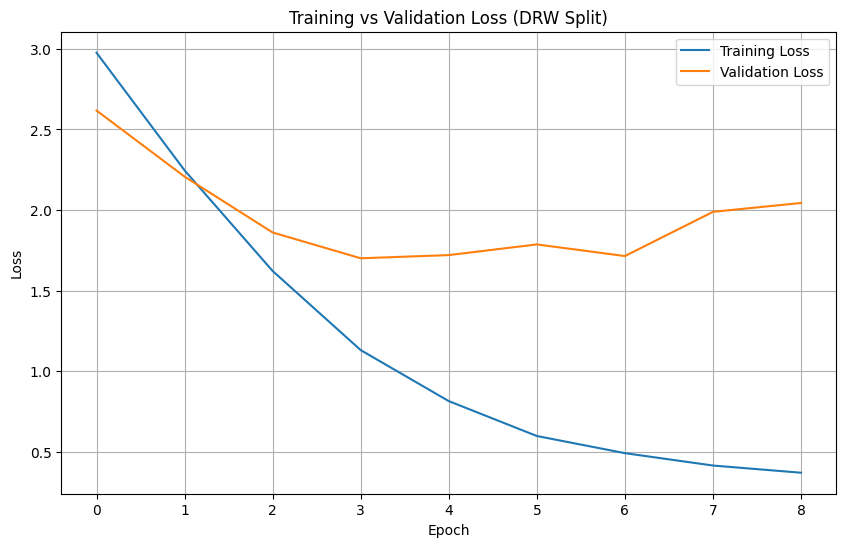

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (DRW Split)")
plt.legend()
plt.grid(True)
plt.show()


### Confusion Matrix for Model 4

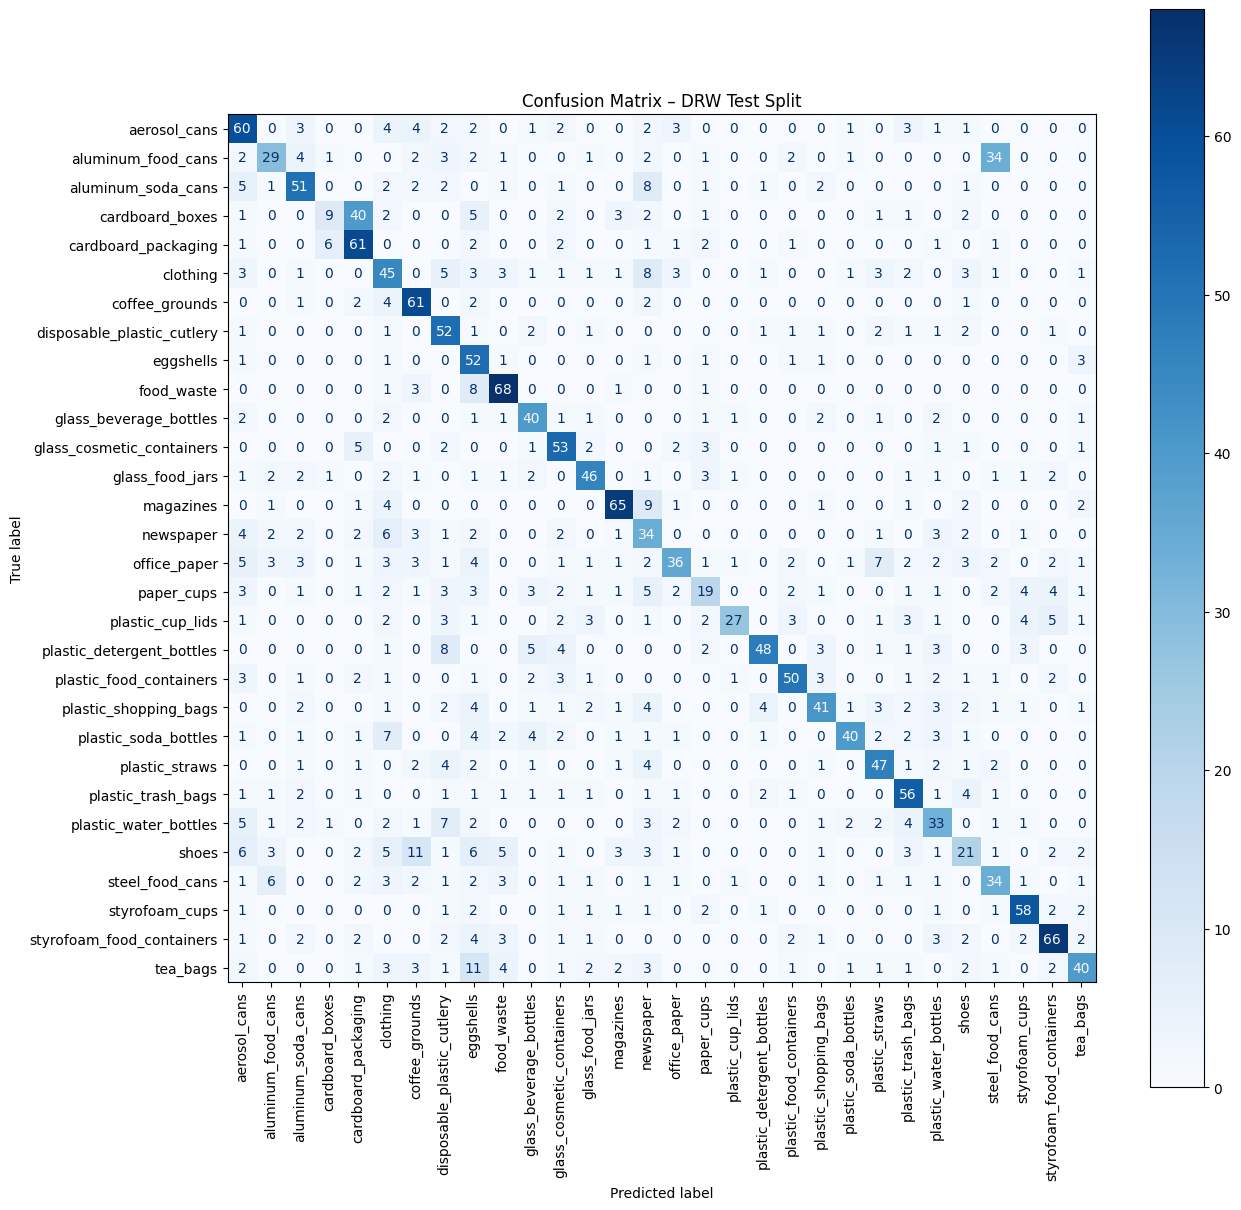

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load best model
model.load_state_dict(torch.load("best_model_drw.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in drw_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – DRW Test Split")
plt.show()


### Accuracy by Category for Model 4

In [34]:
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for images, labels in drw_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for label, prediction in zip(labels, predicted):
            class_total[label] += 1
            if label == prediction:
                class_correct[label] += 1

print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-"*40)
for i, class_name in enumerate(full_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 67.42%
aluminum_food_cans             — Accuracy: 34.12%
aluminum_soda_cans             — Accuracy: 65.38%
cardboard_boxes                — Accuracy: 13.04%
cardboard_packaging            — Accuracy: 77.22%
clothing                       — Accuracy: 51.72%
coffee_grounds                 — Accuracy: 83.56%
disposable_plastic_cutlery     — Accuracy: 76.47%
eggshells                      — Accuracy: 83.87%
food_waste                     — Accuracy: 82.93%
glass_beverage_bottles         — Accuracy: 71.43%
glass_cosmetic_containers      — Accuracy: 74.65%
glass_food_jars                — Accuracy: 65.71%
magazines                      — Accuracy: 74.71%
newspaper                      — Accuracy: 51.52%
office_paper                   — Accuracy: 40.91%
paper_cups                     — Accuracy: 30.16%
plastic_cup_lids               — Accuracy: 45.00%
plastic_detergent_bottles 

### Totaly Accuracy for Model 4

In [35]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy (DRW): {overall_acc:.2f}%")


✅ Overall Test Accuracy (DRW): 59.64%


## MODEL 5: Same Model, Same Anti-Overfitting, Using Image Modifications and Increasing Epochs, Uses Random Split

Using device: cpu


Epoch 1 | Train Loss: 3.4177 | Val Loss: 3.4015


Epoch 2 | Train Loss: 3.4016 | Val Loss: 3.3939


Epoch 3 | Train Loss: 3.3318 | Val Loss: 3.1859


Epoch 4 | Train Loss: 3.1201 | Val Loss: 2.8820


Epoch 5 | Train Loss: 2.9376 | Val Loss: 2.8182


Epoch 6 | Train Loss: 2.7912 | Val Loss: 2.6086


Epoch 7 | Train Loss: 2.7276 | Val Loss: 2.4733


Epoch 8 | Train Loss: 2.6325 | Val Loss: 2.4004


Epoch 9 | Train Loss: 2.5768 | Val Loss: 2.3359


Epoch 10 | Train Loss: 2.5192 | Val Loss: 2.2651


Epoch 11 | Train Loss: 2.4620 | Val Loss: 2.2483


Epoch 12 | Train Loss: 2.4428 | Val Loss: 2.1805


Epoch 13 | Train Loss: 2.3903 | Val Loss: 2.1768


Epoch 14 | Train Loss: 2.3721 | Val Loss: 2.1101


Epoch 15 | Train Loss: 2.3202 | Val Loss: 2.0929


Epoch 16 | Train Loss: 2.3075 | Val Loss: 2.0563


Epoch 17 | Train Loss: 2.2892 | Val Loss: 2.0748


Epoch 18 | Train Loss: 2.2632 | Val Loss: 1.9873


Epoch 19 | Train Loss: 2.2196 | Val Loss: 2.0135


Epoch 20 | Train Loss: 2.2003 | Val Loss: 2.0098


Epoch 21 | Train Loss: 2.2049 | Val Loss: 1.9696


Epoch 22 | Train Loss: 2.1832 | Val Loss: 1.9485


Epoch 23 | Train Loss: 2.1456 | Val Loss: 1.9576


Epoch 24 | Train Loss: 2.1381 | Val Loss: 1.9110


Epoch 25 | Train Loss: 2.1038 | Val Loss: 1.9468


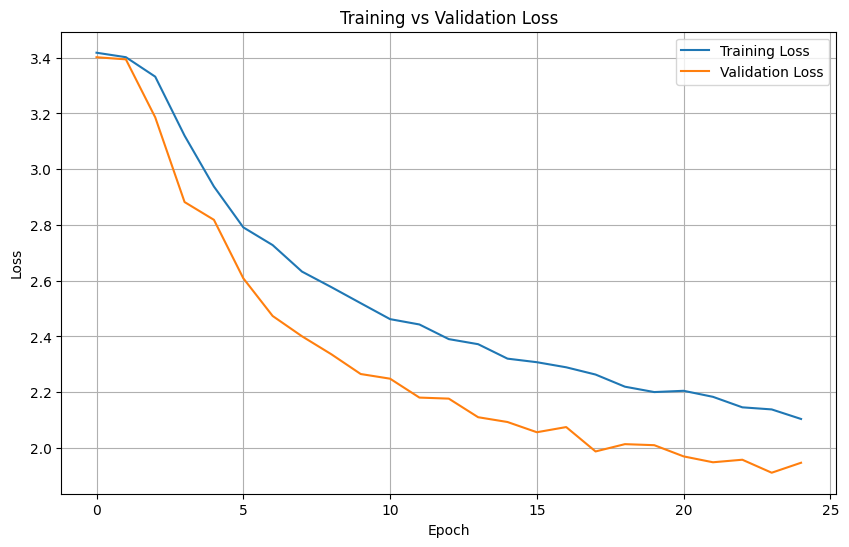

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# DATA AUGMENTATION TRANSFORMS (for training set only)
# ----------------------
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),                  # Randomly flip image horizontally
    transforms.RandomRotation(15),                      # Rotate image by ±15 degrees
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),# Randomly zoom into the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Slight brightness/contrast tweaks
    transforms.ToTensor(),                              # Convert PIL to tensor
])

transform_val = transforms.ToTensor()  # No augmentation for validation

# ----------------------
# DATASET LOADING
# ----------------------
# You must re-define the dataset using these transforms for split
augmented_train_dataset = ImageFolder("images/", transform=transform_augmented)
val_dataset = ImageFolder("images/", transform=transform_val)

# Use previous index splits from random_train_dataset and random_val_dataset
train_loader = DataLoader(torch.utils.data.Subset(augmented_train_dataset, random_train_dataset.indices), batch_size=32, shuffle=True)
val_loader = DataLoader(torch.utils.data.Subset(val_dataset, random_val_dataset.indices), batch_size=32, shuffle=False)

# ----------------------
# MODEL DEFINITION (with Dropout)
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(p=0.5)  # Randomly zeroes 50% of neurons during training
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Applies dropout during training only
        x = self.fc2(x)
        return x

# ----------------------
# INITIALIZATION
# ----------------------
num_classes = len(augmented_train_dataset.classes)
model = WasteClassifierCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# ----------------------
# TRAINING LOOP (with Early Stopping + Val Loss Tracking)
# ----------------------
num_epochs = 25
patience = 3
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    # Training Loss
    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # Validation Loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
# ----------------------
# ACCURACY: Per-Class + Real-World vs Default Breakdown
# ----------------------

# Correct test loader (no augmentation)
test_loader = DataLoader(torch.utils.data.Subset(val_dataset, random_test_dataset.indices), batch_size=32, shuffle=False)

class_correct = [0] * num_classes
class_total = [0] * num_classes

default_correct = 0
default_total = 0
real_correct = 0
real_total = 0

# Get file paths for all test indices
test_paths = [val_dataset.samples[i][0] for i in random_test_dataset.indices]

# Disable gradient computation
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j]
            pred_label = predicted[j]
            class_total[true_label] += 1
            if true_label == pred_label:
                class_correct[true_label] += 1

            # Path of the current sample (use index from test_loader batch + base i)
            img_index = i * test_loader.batch_size + j
            path = test_paths[img_index]
            if "default" in path:
                default_total += 1
                if true_label == pred_label:
                    default_correct += 1
            elif "real_world" in path:
                real_total += 1
                if true_label == pred_label:
                    real_correct += 1

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-" * 40)
for i, class_name in enumerate(augmented_train_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# DEFAULT vs REAL-WORLD ACCURACY
# ----------------------
default_acc = 100 * default_correct / default_total if default_total > 0 else 0.0
real_acc = 100 * real_correct / real_total if real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type:\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {default_acc:.2f}% ({default_correct}/{default_total})")
print(f"Real-World Photos   — Accuracy: {real_acc:.2f}% ({real_correct}/{real_total})")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 26.92%
aluminum_food_cans             — Accuracy: 69.51%
aluminum_soda_cans             — Accuracy: 18.18%
cardboard_boxes                — Accuracy: 25.64%
cardboard_packaging            — Accuracy: 61.19%
clothing                       — Accuracy: 40.00%
coffee_grounds                 — Accuracy: 84.93%
disposable_plastic_cutlery     — Accuracy: 40.91%
eggshells                      — Accuracy: 41.79%
food_waste                     — Accuracy: 84.62%
glass_beverage_bottles         — Accuracy: 53.57%
glass_cosmetic_containers      — Accuracy: 17.50%
glass_food_jars                — Accuracy: 57.14%
magazines                      — Accuracy: 73.97%
newspaper                      — Accuracy: 41.77%
office_paper                   — Accuracy: 16.25%
paper_cups                     — Accuracy: 32.89%
plastic_cup_lids               — Accuracy: 23.94%
plastic_detergent_bottles 

In [41]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy (Random Split): {overall_acc:.2f}%")


✅ Overall Test Accuracy (Random Split): 44.67%


It seems like though data augmentation did allow us to train for longer without early stopping, it also had a significant impact on our accuracy.  Below we try softening the augmentations and only implementing them after the first several epochs.

# MODEL 6: Same as 5 but softened augmentations, normalization of channels, delayed augmentation

Using device: cpu

Epoch 1/25


→ Train Loss: 3.0700 | Val Loss: 2.6178

Epoch 2/25


→ Train Loss: 2.2827 | Val Loss: 1.8970

Epoch 3/25


→ Train Loss: 1.4954 | Val Loss: 1.6692

Epoch 4/25


→ Train Loss: 0.9110 | Val Loss: 1.5401

Epoch 5/25


→ Train Loss: 0.5537 | Val Loss: 1.6364

Epoch 6/25


→ Train Loss: 1.8658 | Val Loss: 1.3797

Epoch 7/25


→ Train Loss: 1.4863 | Val Loss: 1.3591

Epoch 8/25


→ Train Loss: 1.2898 | Val Loss: 1.3642

Epoch 9/25


→ Train Loss: 1.1574 | Val Loss: 1.3141

Epoch 10/25


→ Train Loss: 1.0274 | Val Loss: 1.3393

Epoch 11/25


→ Train Loss: 0.9484 | Val Loss: 1.3595

Epoch 12/25


→ Train Loss: 0.8766 | Val Loss: 1.3458
Early stopping triggered after 12 epochs.


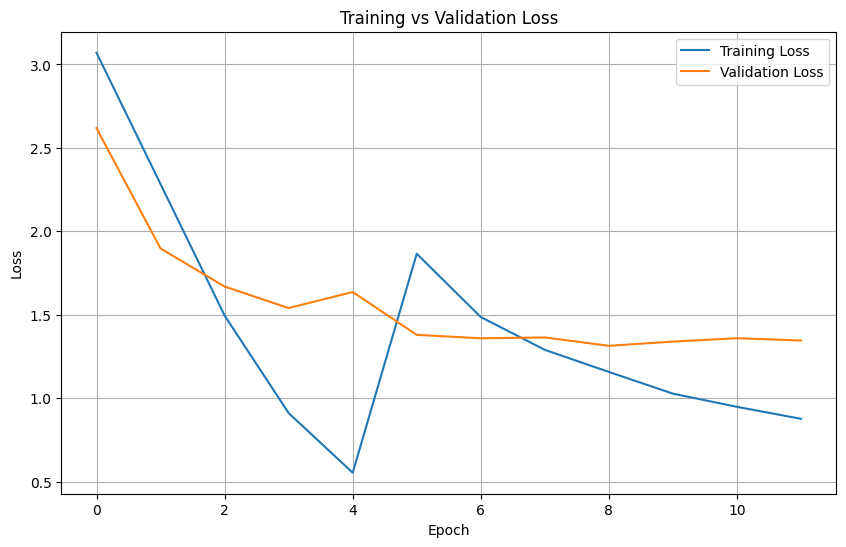

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# TRANSFORMS
# ----------------------
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_plain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ----------------------
# DATASETS USING EXISTING SPLITS
# ----------------------
base_train_dataset = ImageFolder("images/", transform=transform_plain)
val_dataset = ImageFolder("images/", transform=transform_plain)

# Replace with your actual precomputed splits
train_idx = double_strat_train_dataset.indices
val_idx = double_strat_val_dataset.indices

# ----------------------
# MODEL DEFINITION
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ----------------------
# INITIALIZATION
# ----------------------
num_classes = len(base_train_dataset.classes)
model = WasteClassifierCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# ----------------------
# TRAINING LOOP
# ----------------------
num_epochs = 25
patience = 3
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Switch to augmentation after epoch 5
    base_train_dataset.transform = transform_augmented if epoch >= 5 else transform_plain

    train_loader = DataLoader(Subset(base_train_dataset, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=32, shuffle=False)

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # ----------------------
    # VALIDATION
    # ----------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)
    print(f"→ Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ----------------------
    # EARLY STOPPING
    # ----------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model6.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# ----------------------
# LOAD BEST MODEL FOR MODEL 6
# ----------------------
model.load_state_dict(torch.load("best_model6.pt"))
model.eval()

# ----------------------
# TEST LOADER + PATHS (DOUBLE STRATIFIED)
# ----------------------
test_loader = DataLoader(torch.utils.data.Subset(val_dataset, double_strat_test_dataset.indices), batch_size=32, shuffle=False)
test_paths_model6 = [val_dataset.samples[i][0] for i in double_strat_test_dataset.indices]

# ----------------------
# ACCURACY STATS (Model 6)
# ----------------------
model6_class_correct = [0] * num_classes
model6_class_total = [0] * num_classes
model6_default_correct = 0
model6_default_total = 0
model6_real_correct = 0
model6_real_total = 0

model6_all_preds = []
model6_all_labels = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j].item()
            pred_label = predicted[j].item()
            model6_class_total[true_label] += 1
            if true_label == pred_label:
                model6_class_correct[true_label] += 1

            # Access path based on correct image index
            img_index = i * test_loader.batch_size + j
            path = test_paths_model6[img_index]
            if "default" in path:
                model6_default_total += 1
                if true_label == pred_label:
                    model6_default_correct += 1
            elif "real_world" in path:
                model6_real_total += 1
                if true_label == pred_label:
                    model6_real_correct += 1

            model6_all_preds.append(pred_label)
            model6_all_labels.append(true_label)

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown (Model 6):\n" + "-" * 40)
for i, class_name in enumerate(val_dataset.classes):
    acc = 100 * model6_class_correct[i] / model6_class_total[i] if model6_class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# DEFAULT vs REAL-WORLD ACCURACY
# ----------------------
model6_default_acc = 100 * model6_default_correct / model6_default_total if model6_default_total > 0 else 0.0
model6_real_acc = 100 * model6_real_correct / model6_real_total if model6_real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type (Model 6):\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {model6_default_acc:.2f}% ({model6_default_correct}/{model6_default_total})")
print(f"Real-World Photos   — Accuracy: {model6_real_acc:.2f}% ({model6_real_correct}/{model6_real_total})")

# ----------------------
# OVERALL ACCURACY
# ----------------------
model6_total_correct = sum(model6_class_correct)
model6_total_samples = sum(model6_class_total)
model6_overall_acc = 100 * model6_total_correct / model6_total_samples
print(f"\n✅ Overall Test Accuracy (Model 6 – Double Stratified): {model6_overall_acc:.2f}%")


🔍 Per-Class Accuracy Breakdown (Model 6):
----------------------------------------
aerosol_cans                   — Accuracy: 60.00%
aluminum_food_cans             — Accuracy: 57.33%
aluminum_soda_cans             — Accuracy: 63.51%
cardboard_boxes                — Accuracy: 66.67%
cardboard_packaging            — Accuracy: 41.89%
clothing                       — Accuracy: 65.79%
coffee_grounds                 — Accuracy: 90.54%
disposable_plastic_cutlery     — Accuracy: 70.67%
eggshells                      — Accuracy: 66.67%
food_waste                     — Accuracy: 89.33%
glass_beverage_bottles         — Accuracy: 69.74%
glass_cosmetic_containers      — Accuracy: 65.79%
glass_food_jars                — Accuracy: 74.67%
magazines                      — Accuracy: 80.00%
newspaper                      — Accuracy: 73.68%
office_paper                   — Accuracy: 40.54%
paper_cups                     — Accuracy: 57.33%
plastic_cup_lids               — Accuracy: 57.33%
plastic_detergen

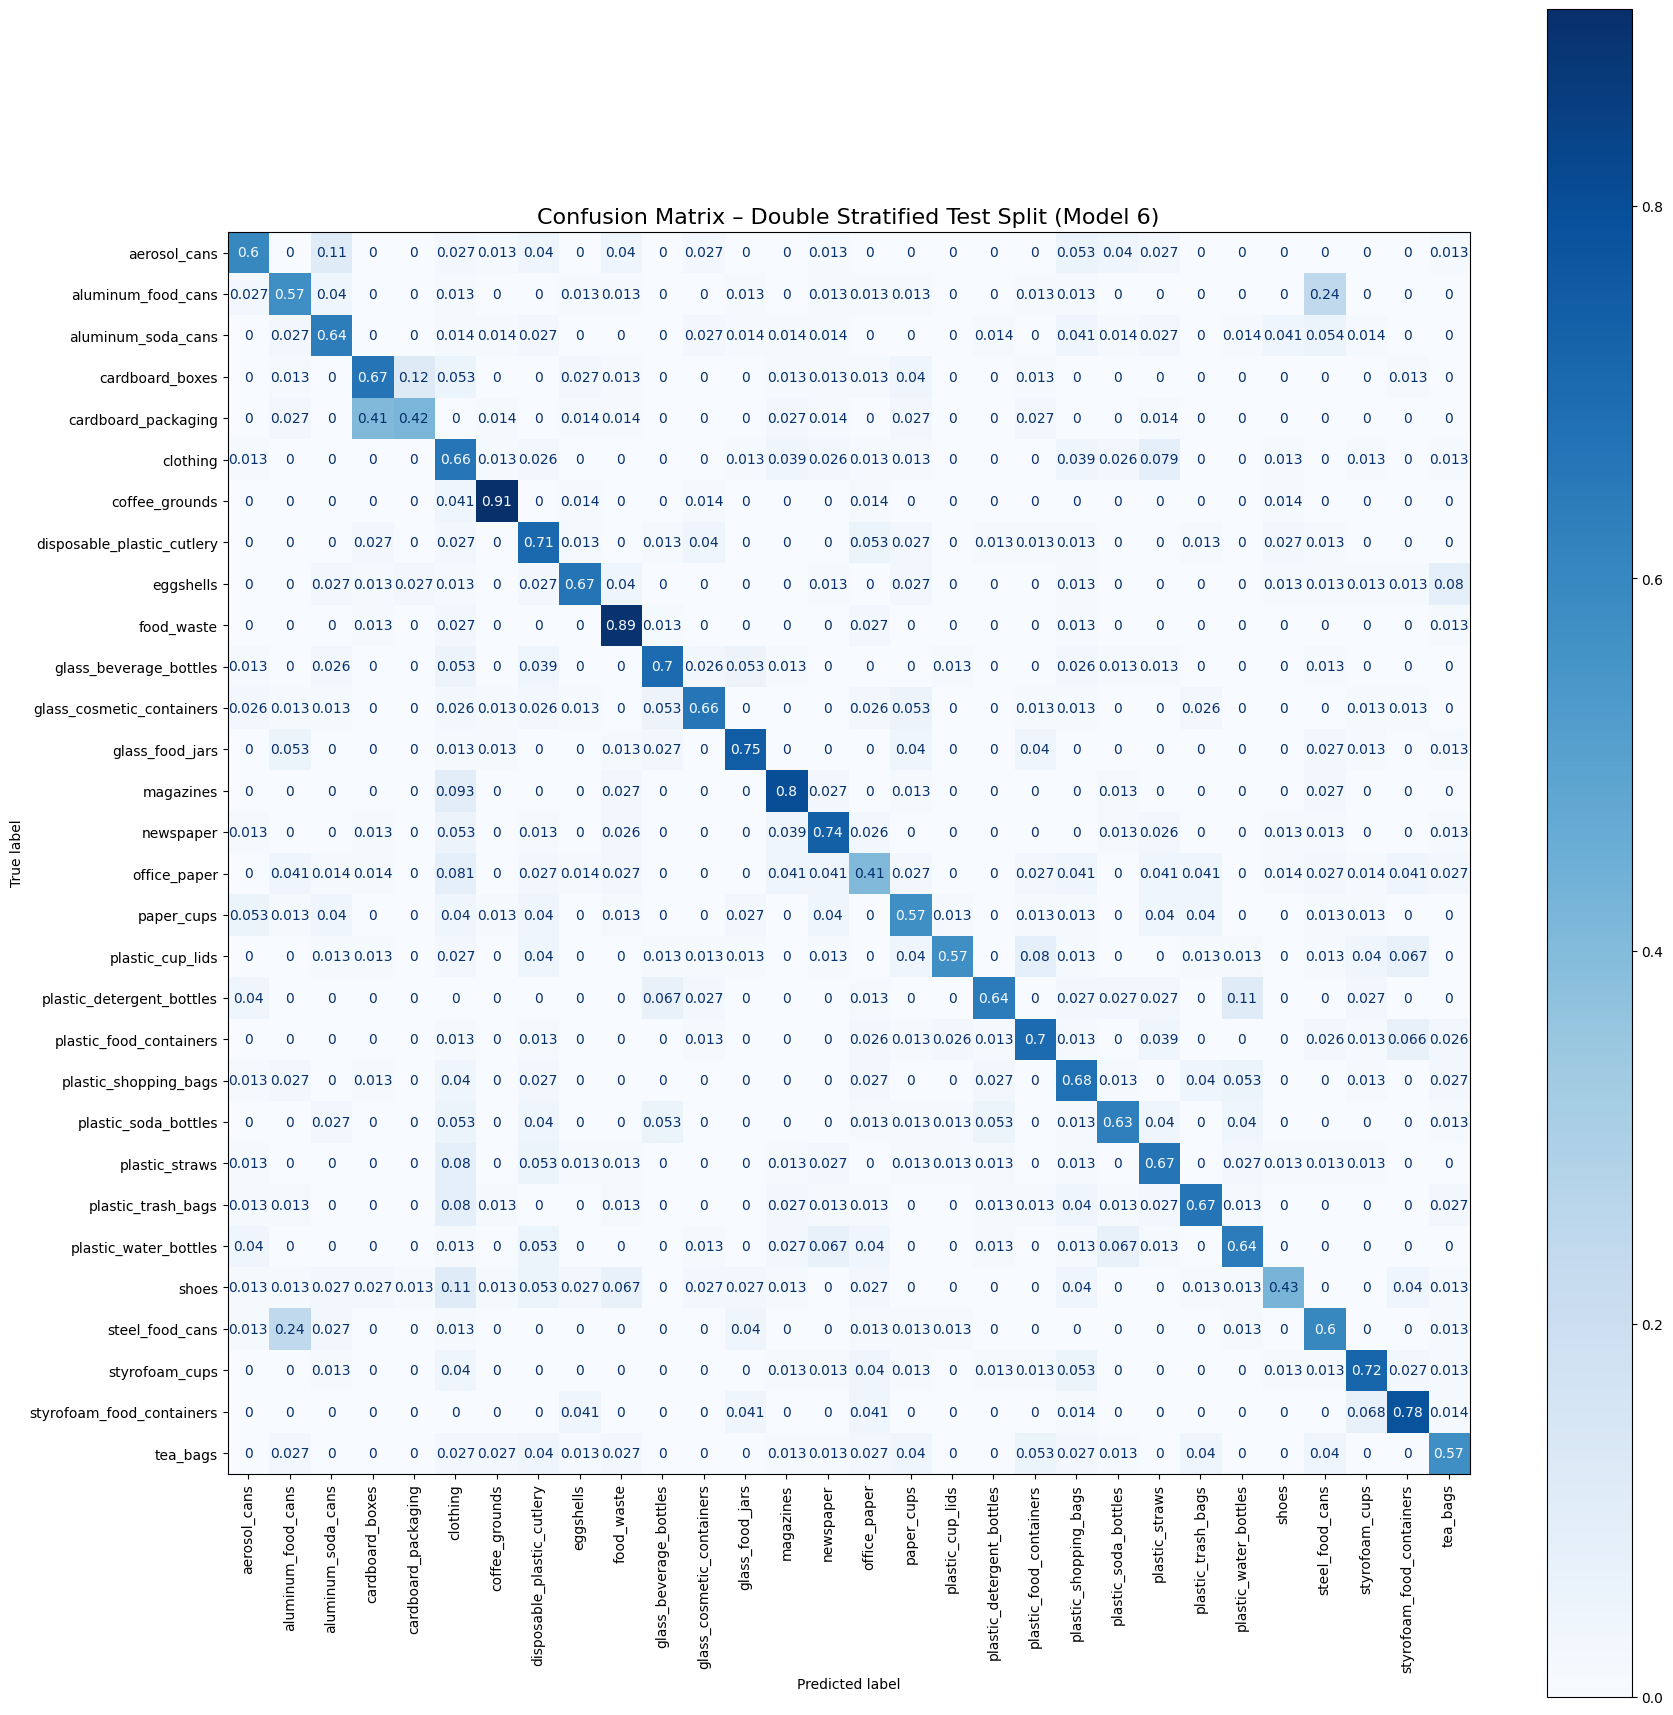

In [11]:
# ----------------------
# CONFUSION MATRIX (Normalized – Model 6)
# ----------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_model6 = confusion_matrix(model6_all_labels, model6_all_preds, normalize="true")
disp_model6 = ConfusionMatrixDisplay(confusion_matrix=cm_model6, display_labels=val_dataset.classes)

fig, ax = plt.subplots(figsize=(18, 18))
disp_model6.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)

# Improve font size and layout
ax.set_xticklabels(val_dataset.classes, fontsize=10, rotation=90)
ax.set_yticklabels(val_dataset.classes, fontsize=10)
plt.title("Confusion Matrix – Double Stratified Test Split (Model 6)", fontsize=16)
plt.tight_layout()
plt.show()


# MODEL 7: First Attempt At Transfer Learning w/ ResNet

Using device: cpu


Epoch 1 | Train Loss: 2.2007 | Val Loss: 1.2272


Epoch 2 | Train Loss: 1.5016 | Val Loss: 1.0614


Epoch 3 | Train Loss: 1.3611 | Val Loss: 0.9629


Epoch 4 | Train Loss: 1.2910 | Val Loss: 0.9463


Epoch 5 | Train Loss: 1.2429 | Val Loss: 0.9024


Epoch 6 | Train Loss: 1.1793 | Val Loss: 0.8854


Epoch 7 | Train Loss: 1.1664 | Val Loss: 0.8699


Epoch 8 | Train Loss: 1.1354 | Val Loss: 0.8534


Epoch 9 | Train Loss: 1.1403 | Val Loss: 0.8488


Epoch 10 | Train Loss: 1.0944 | Val Loss: 0.8527


Epoch 11 | Train Loss: 1.0830 | Val Loss: 0.8002


Epoch 12 | Train Loss: 1.0762 | Val Loss: 0.8053


Epoch 13 | Train Loss: 1.0420 | Val Loss: 0.8082


Epoch 14 | Train Loss: 1.0579 | Val Loss: 0.7965


Epoch 15 | Train Loss: 1.0448 | Val Loss: 0.8209


Epoch 16 | Train Loss: 1.0188 | Val Loss: 0.8134


Epoch 17 | Train Loss: 1.0216 | Val Loss: 0.7752


Epoch 18 | Train Loss: 0.9975 | Val Loss: 0.7963


Epoch 19 | Train Loss: 1.0074 | Val Loss: 0.7928


Epoch 20 | Train Loss: 1.0056 | Val Loss: 0.7670


Epoch 21 | Train Loss: 0.9915 | Val Loss: 0.7674


Epoch 22 | Train Loss: 0.9834 | Val Loss: 0.7684


Epoch 23 | Train Loss: 0.9502 | Val Loss: 0.7803
Early stopping triggered after 23 epochs.


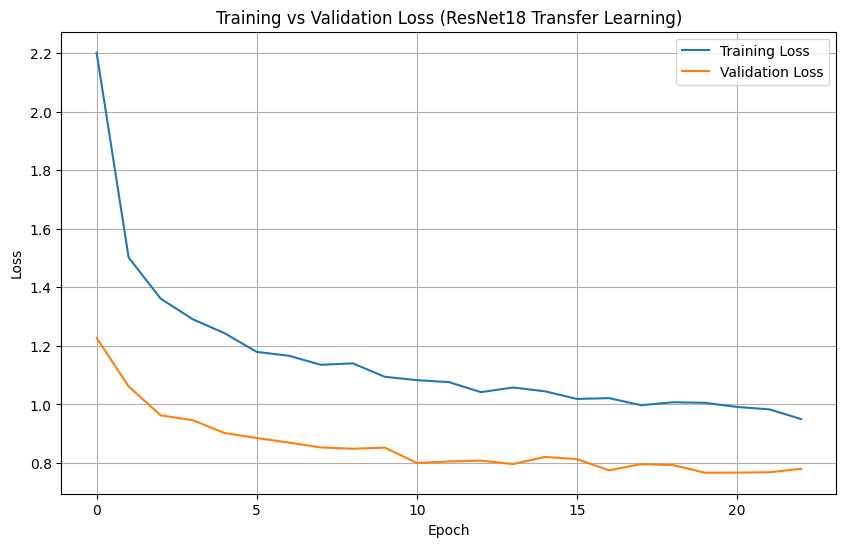

In [28]:
# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# DATA TRANSFORMS (ResNet expects 224x224 and ImageNet normalization)
# ----------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ----------------------
# DATASETS AND LOADERS (based on your precomputed splits)
# ----------------------
full_dataset_train = ImageFolder("images/", transform=transform_train)
full_dataset_val = ImageFolder("images/", transform=transform_val)

train_loader = DataLoader(torch.utils.data.Subset(full_dataset_train, double_strat_train_dataset.indices), batch_size=32, shuffle=True)
val_loader = DataLoader(torch.utils.data.Subset(full_dataset_val, double_strat_val_dataset.indices), batch_size=32, shuffle=False)

# ----------------------
# MODEL SETUP (Transfer Learning with ResNet18)
# ----------------------
num_classes = len(full_dataset_train.classes)
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

model = model.to(device)

# ----------------------
# LOSS FUNCTION & OPTIMIZER
# ----------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-4)

# ----------------------
# TRAINING LOOP WITH EARLY STOPPING
# ----------------------
num_epochs = 25
patience = 3
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    # Save training loss
    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # ----------------------
    # VALIDATION LOOP
    # ----------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ----------------------
    # EARLY STOPPING
    # ----------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_resnet_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (ResNet18 Transfer Learning)")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# ----------------------
# LOAD BEST MODEL FOR RESNET18
# ----------------------
model.load_state_dict(torch.load("best_resnet_model.pt"))
model.eval()

# ----------------------
# TEST LOADER + PATHS (DOUBLE STRATIFIED)
# ----------------------
resnet_test_loader = DataLoader(torch.utils.data.Subset(full_dataset_val, double_strat_test_dataset.indices), batch_size=32, shuffle=False)
resnet_test_paths = [full_dataset_val.samples[i][0] for i in double_strat_test_dataset.indices]

# ----------------------
# ACCURACY STATS (RESNET)
# ----------------------
resnet_class_correct = [0] * num_classes
resnet_class_total = [0] * num_classes
resnet_default_correct = 0
resnet_default_total = 0
resnet_real_correct = 0
resnet_real_total = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(resnet_test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j].item()
            pred_label = predicted[j].item()
            resnet_class_total[true_label] += 1
            if true_label == pred_label:
                resnet_class_correct[true_label] += 1

            img_index = i * resnet_test_loader.batch_size + j
            path = resnet_test_paths[img_index]
            if "default" in path:
                resnet_default_total += 1
                if true_label == pred_label:
                    resnet_default_correct += 1
            elif "real_world" in path:
                resnet_real_total += 1
                if true_label == pred_label:
                    resnet_real_correct += 1

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown (ResNet18):\n" + "-" * 40)
for i, class_name in enumerate(full_dataset_val.classes):
    acc = 100 * resnet_class_correct[i] / resnet_class_total[i] if resnet_class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# DEFAULT vs REAL-WORLD ACCURACY
# ----------------------
resnet_default_acc = 100 * resnet_default_correct / resnet_default_total if resnet_default_total > 0 else 0.0
resnet_real_acc = 100 * resnet_real_correct / resnet_real_total if resnet_real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type (ResNet18):\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {resnet_default_acc:.2f}% ({resnet_default_correct}/{resnet_default_total})")
print(f"Real-World Photos   — Accuracy: {resnet_real_acc:.2f}% ({resnet_real_correct}/{resnet_real_total})")

# ----------------------
# OVERALL ACCURACY
# ----------------------
resnet_total_correct = sum(resnet_class_correct)
resnet_total_samples = sum(resnet_class_total)
resnet_overall_acc = 100 * resnet_total_correct / resnet_total_samples

print(f"\n✅ Overall Test Accuracy (ResNet18 – Double Stratified): {resnet_overall_acc:.2f}%")




🔍 Per-Class Accuracy Breakdown (ResNet18):
----------------------------------------
aerosol_cans                   — Accuracy: 72.00%
aluminum_food_cans             — Accuracy: 32.00%
aluminum_soda_cans             — Accuracy: 75.68%
cardboard_boxes                — Accuracy: 21.33%
cardboard_packaging            — Accuracy: 71.62%
clothing                       — Accuracy: 81.58%
coffee_grounds                 — Accuracy: 91.89%
disposable_plastic_cutlery     — Accuracy: 88.00%
eggshells                      — Accuracy: 92.00%
food_waste                     — Accuracy: 81.33%
glass_beverage_bottles         — Accuracy: 80.26%
glass_cosmetic_containers      — Accuracy: 81.58%
glass_food_jars                — Accuracy: 66.67%
magazines                      — Accuracy: 66.67%
newspaper                      — Accuracy: 82.89%
office_paper                   — Accuracy: 58.11%
paper_cups                     — Accuracy: 66.67%
plastic_cup_lids               — Accuracy: 70.67%
plastic_deterge

# Model 8: First Attempt w/ EfficientNet-B0

Using device: cpu


/Users/lukestockbridge/miniconda3/envs/nn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/lukestockbridge/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████████████████████████████████| 20.5M/20.5M [00:01<00:00, 15.0MB/s]
                                                                                

Epoch 1 | Train Loss: 1.8924 | Val Loss: 1.0774


Epoch 2 | Train Loss: 1.2553 | Val Loss: 0.8713


Epoch 3 | Train Loss: 1.1333 | Val Loss: 0.8305


Epoch 4 | Train Loss: 1.0502 | Val Loss: 0.7682


Epoch 5 | Train Loss: 1.0034 | Val Loss: 0.7679


Epoch 6 | Train Loss: 0.9610 | Val Loss: 0.7616


Epoch 7 | Train Loss: 0.9447 | Val Loss: 0.7253


Epoch 8 | Train Loss: 0.9260 | Val Loss: 0.7149


Epoch 9 | Train Loss: 0.8917 | Val Loss: 0.6883


Epoch 10 | Train Loss: 0.8789 | Val Loss: 0.6851


Epoch 11 | Train Loss: 0.8673 | Val Loss: 0.6987


Epoch 12 | Train Loss: 0.8449 | Val Loss: 0.6698


Epoch 13 | Train Loss: 0.8373 | Val Loss: 0.6599


Epoch 14 | Train Loss: 0.8315 | Val Loss: 0.6761


Epoch 15 | Train Loss: 0.8390 | Val Loss: 0.6447


Epoch 16 | Train Loss: 0.8210 | Val Loss: 0.6626


Epoch 17 | Train Loss: 0.8052 | Val Loss: 0.6304


Epoch 18 | Train Loss: 0.8070 | Val Loss: 0.6686


Epoch 19 | Train Loss: 0.7972 | Val Loss: 0.6522


Epoch 20 | Train Loss: 0.7916 | Val Loss: 0.6612
Early stopping triggered after 20 epochs.


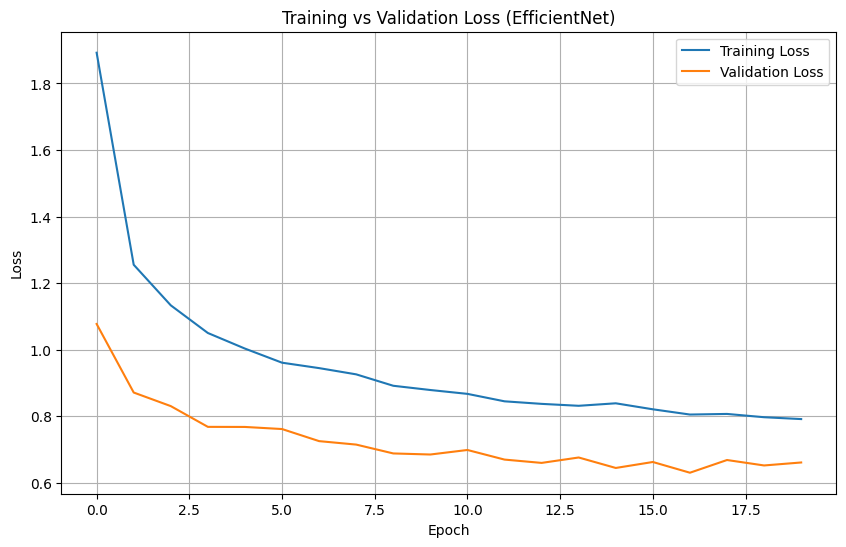

In [52]:
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# TRANSFORMS (224x224 for EfficientNet)
# ----------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ----------------------
# DATASETS + LOADERS
# ----------------------
full_dataset_train = ImageFolder("images/", transform=transform_train)
full_dataset_val = ImageFolder("images/", transform=transform_val)

train_loader = DataLoader(torch.utils.data.Subset(full_dataset_train, double_strat_train_dataset.indices), batch_size=32, shuffle=True)
val_loader = DataLoader(torch.utils.data.Subset(full_dataset_val, double_strat_val_dataset.indices), batch_size=32, shuffle=False)
test_loader = DataLoader(torch.utils.data.Subset(full_dataset_val, double_strat_test_dataset.indices), batch_size=32, shuffle=False)
test_paths = [full_dataset_val.samples[i][0] for i in double_strat_test_dataset.indices]

# ----------------------
# MODEL SETUP (EfficientNet-B0)
# ----------------------
num_classes = len(full_dataset_train.classes)
model = models.efficientnet_b0(pretrained=True)

# Freeze base layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

model = model.to(device)

# ----------------------
# LOSS & OPTIMIZER
# ----------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[1].parameters(), lr=0.001, weight_decay=1e-4)

# ----------------------
# TRAINING LOOP
# ----------------------
num_epochs = 25
patience = 3
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_efficientnet_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (EfficientNet)")
plt.legend()
plt.grid(True)
plt.show()



/Users/lukestockbridge/miniconda3/envs/nn/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lukestockbridge/miniconda3/envs/nn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


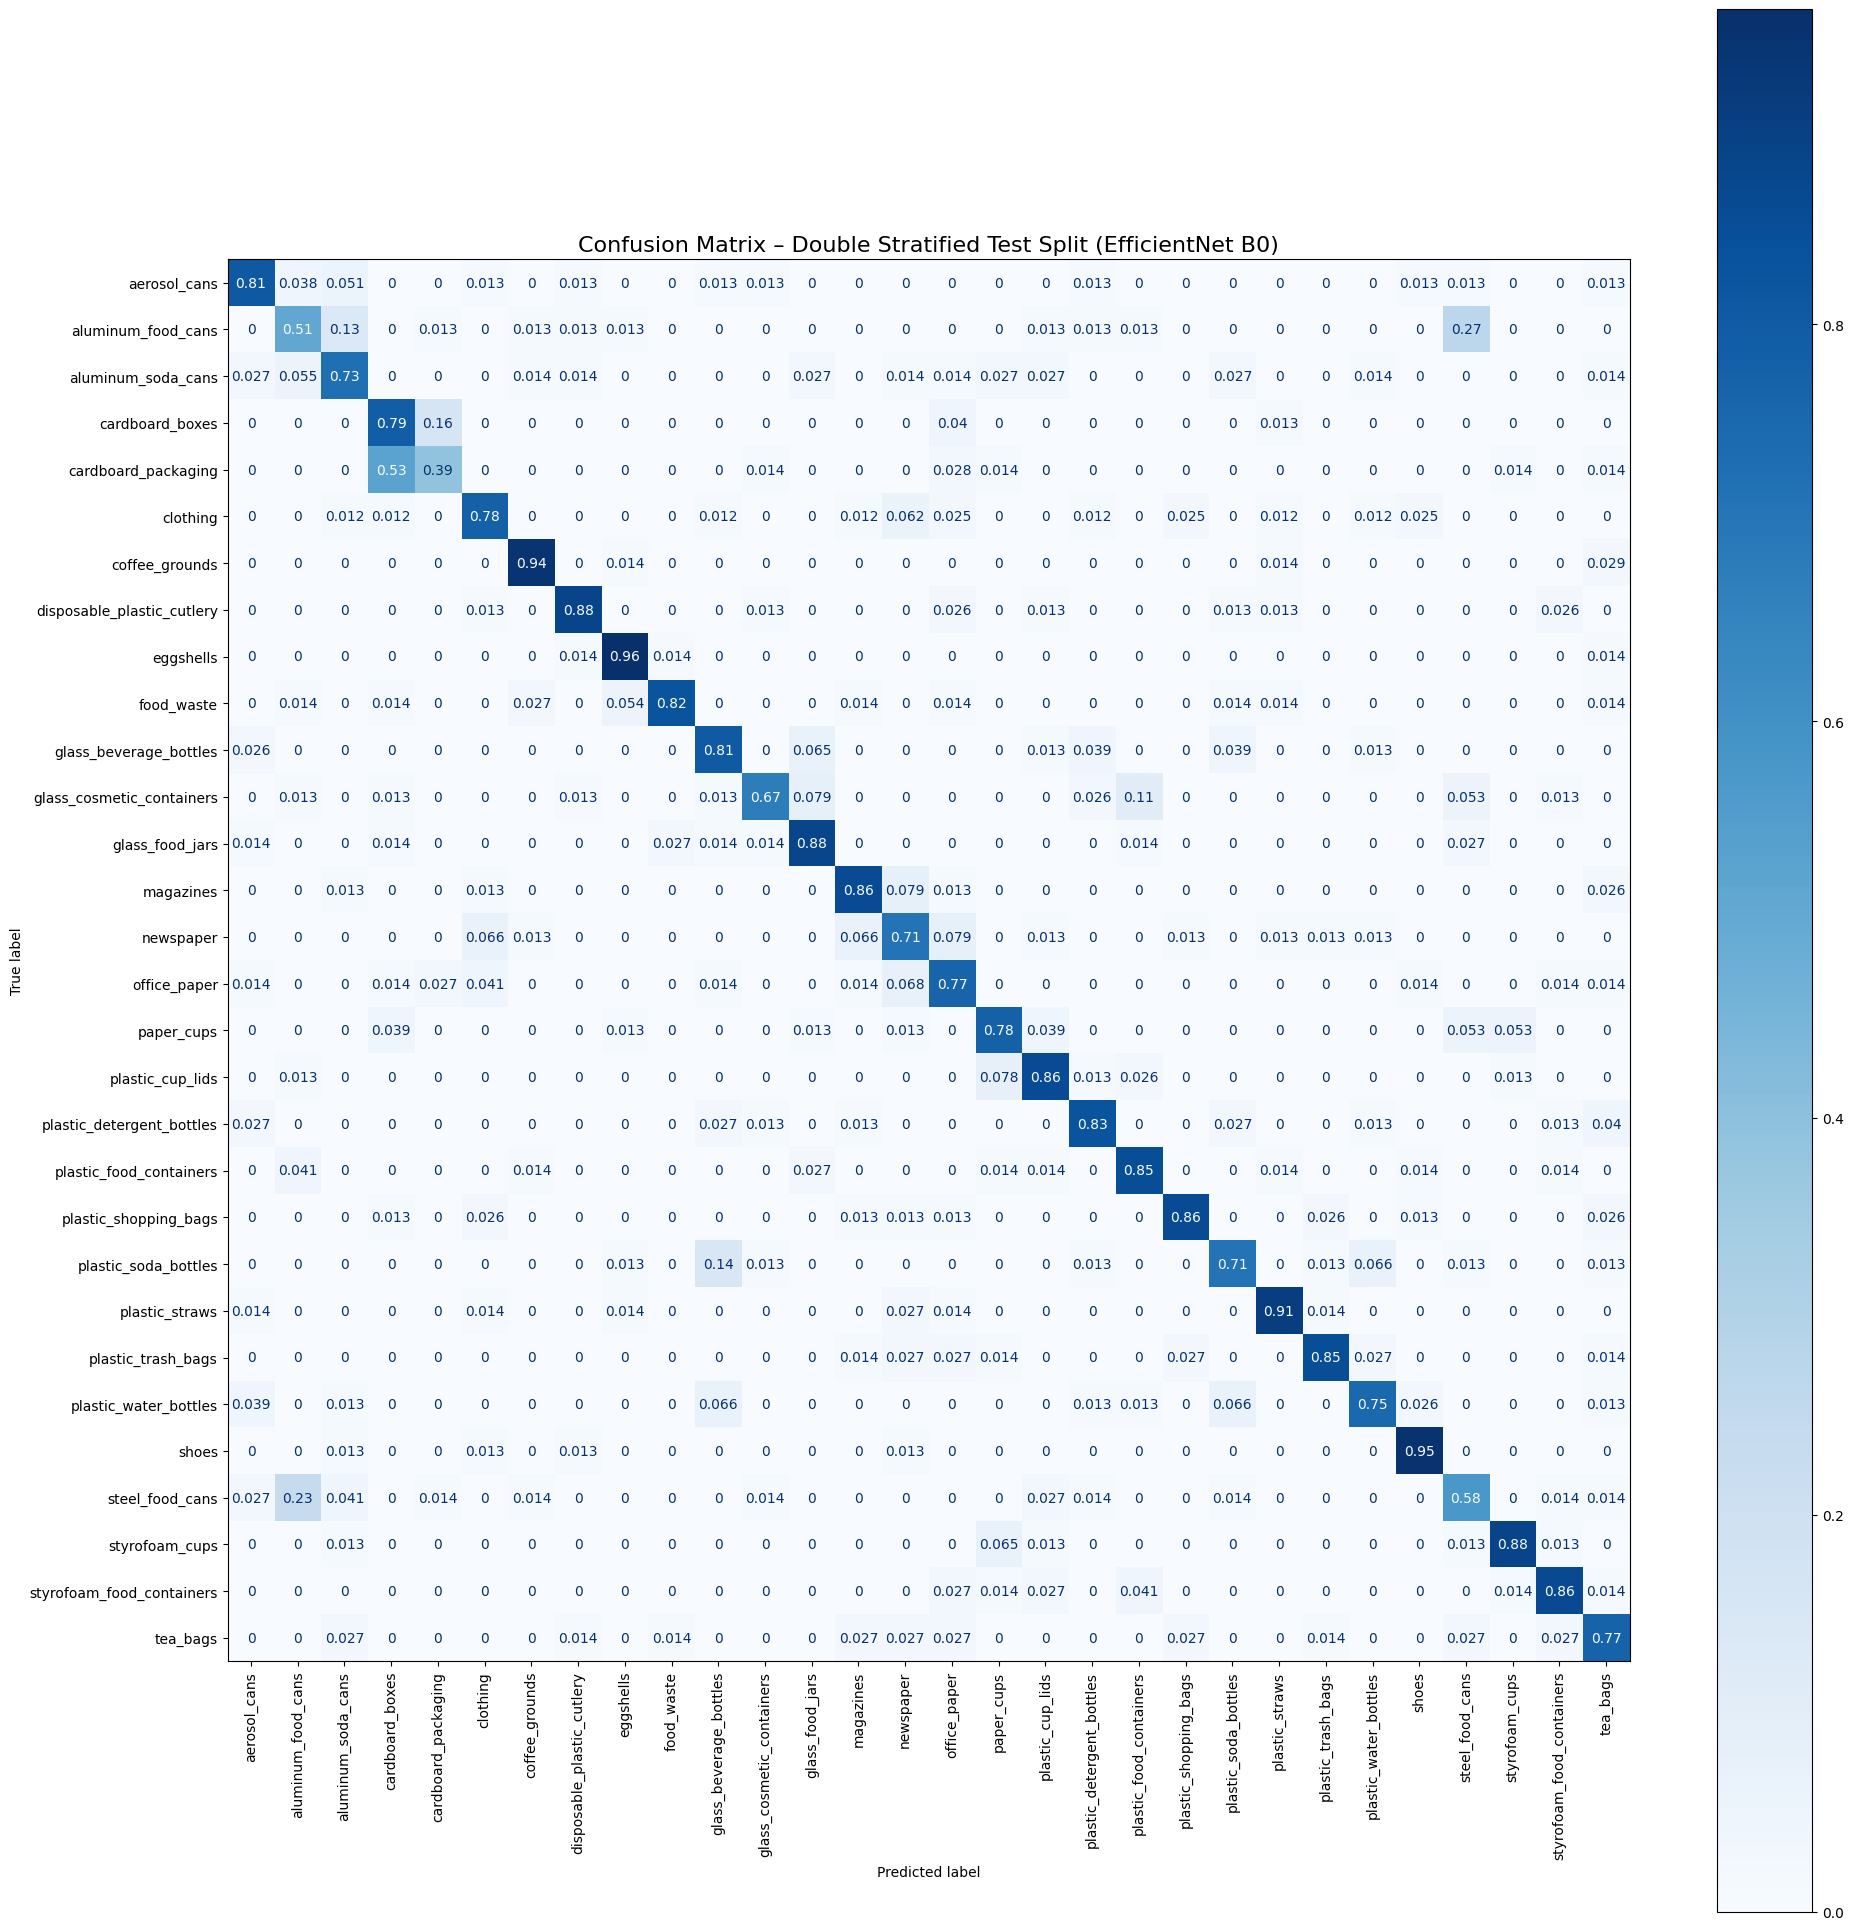


🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 80.77%
aluminum_food_cans             — Accuracy: 50.67%
aluminum_soda_cans             — Accuracy: 72.60%
cardboard_boxes                — Accuracy: 78.67%
cardboard_packaging            — Accuracy: 38.89%
clothing                       — Accuracy: 77.78%
coffee_grounds                 — Accuracy: 94.29%
disposable_plastic_cutlery     — Accuracy: 88.31%
eggshells                      — Accuracy: 95.89%
food_waste                     — Accuracy: 82.43%
glass_beverage_bottles         — Accuracy: 80.52%
glass_cosmetic_containers      — Accuracy: 67.11%
glass_food_jars                — Accuracy: 87.84%
magazines                      — Accuracy: 85.53%
newspaper                      — Accuracy: 71.05%
office_paper                   — Accuracy: 76.71%
paper_cups                     — Accuracy: 77.63%
plastic_cup_lids               — Accuracy: 85.71%
plastic_detergent_bottles 

In [56]:
# Re-initialize the model architecture
model = models.efficientnet_b0(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)
model = model.to(device)

# Load saved best weights
model.load_state_dict(torch.load("best_efficientnet_model.pt"))
model.eval()


# ----------------------
# ACCURACY & BREAKDOWNS (EfficientNet B0)
# ----------------------
b0_class_correct = [0] * num_classes
b0_class_total = [0] * num_classes
b0_default_correct = 0
b0_default_total = 0
b0_real_correct = 0
b0_real_total = 0
b0_all_preds = []
b0_all_labels = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j]
            pred_label = predicted[j]
            b0_class_total[true_label] += 1
            if true_label == pred_label:
                b0_class_correct[true_label] += 1

            path = test_paths[i * test_loader.batch_size + j]
            if "default" in path:
                b0_default_total += 1
                if true_label == pred_label:
                    b0_default_correct += 1
            elif "real_world" in path:
                b0_real_total += 1
                if true_label == pred_label:
                    b0_real_correct += 1

            b0_all_preds.append(pred_label.cpu())
            b0_all_labels.append(true_label.cpu())

# ----------------------
# CONFUSION MATRIX (Normalized)
# ----------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

b0_cm = confusion_matrix(b0_all_labels, b0_all_preds, normalize="true")
b0_disp = ConfusionMatrixDisplay(confusion_matrix=b0_cm, display_labels=full_dataset_val.classes)

fig, ax = plt.subplots(figsize=(20, 20))
b0_disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)

# Improve font size and layout
ax.set_xticklabels(full_dataset_val.classes, fontsize=10, rotation=90)
ax.set_yticklabels(full_dataset_val.classes, fontsize=10)
plt.title("Confusion Matrix – Double Stratified Test Split (EfficientNet B0)", fontsize=16)
plt.tight_layout()
plt.show()

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-" * 40)
for i, class_name in enumerate(full_dataset_val.classes):
    acc = 100 * b0_class_correct[i] / b0_class_total[i] if b0_class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# TYPE-BASED ACCURACY
# ----------------------
b0_default_acc = 100 * b0_default_correct / b0_default_total if b0_default_total > 0 else 0.0
b0_real_acc = 100 * b0_real_correct / b0_real_total if b0_real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type:\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {b0_default_acc:.2f}% ({b0_default_correct}/{b0_default_total})")
print(f"Real-World Photos   — Accuracy: {b0_real_acc:.2f}% ({b0_real_correct}/{b0_real_total})")

# ----------------------
# OVERALL ACCURACY (TEST SET)
# ----------------------
b0_overall_acc = 100 * sum(b0_class_correct) / sum(b0_class_total)
print(f"\n✅ Overall Test Accuracy (Double Stratified - EfficientNet B0): {b0_overall_acc:.2f}%")


# Model 9: First Attempt w/ DenseNet121

/Users/lukestockbridge/miniconda3/envs/nn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu


Epoch 1 | Train Loss: 2.0935 | Val Loss: 1.1658


Epoch 2 | Train Loss: 1.3445 | Val Loss: 0.9929


Epoch 3 | Train Loss: 1.1730 | Val Loss: 0.8723


Epoch 4 | Train Loss: 1.0914 | Val Loss: 0.8200


Epoch 5 | Train Loss: 1.0344 | Val Loss: 0.7633


Epoch 6 | Train Loss: 0.9906 | Val Loss: 0.7332


Epoch 7 | Train Loss: 0.9510 | Val Loss: 0.7346


Epoch 8 | Train Loss: 0.9592 | Val Loss: 0.7302


Epoch 9 | Train Loss: 0.9111 | Val Loss: 0.7018


Epoch 10 | Train Loss: 0.9212 | Val Loss: 0.6969


Epoch 11 | Train Loss: 0.8853 | Val Loss: 0.6770


Epoch 12 | Train Loss: 0.8594 | Val Loss: 0.6908


Epoch 13 | Train Loss: 0.8521 | Val Loss: 0.6924


Epoch 14 | Train Loss: 0.8427 | Val Loss: 0.6612


Epoch 15 | Train Loss: 0.8231 | Val Loss: 0.6605


Epoch 16 | Train Loss: 0.8267 | Val Loss: 0.6632


Epoch 17 | Train Loss: 0.7914 | Val Loss: 0.6373


Epoch 18 | Train Loss: 0.7875 | Val Loss: 0.6439


Epoch 19 | Train Loss: 0.7972 | Val Loss: 0.6519


Epoch 20 | Train Loss: 0.7794 | Val Loss: 0.6561
Early stopping triggered after 20 epochs.


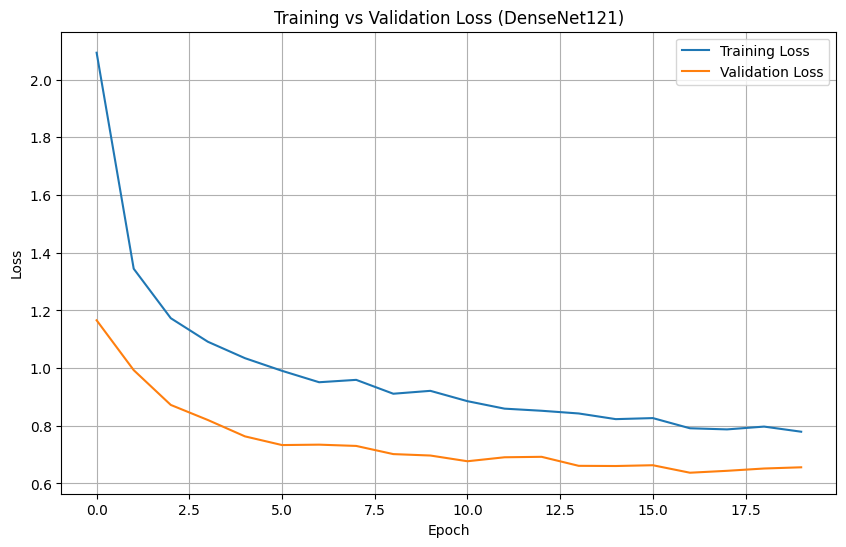

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# DATA TRANSFORMS
# ----------------------
transform_train_densenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_val_densenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ----------------------
# DATASETS AND LOADERS
# ----------------------
full_dataset_train_densenet = ImageFolder("images/", transform=transform_train_densenet)
full_dataset_val_densenet = ImageFolder("images/", transform=transform_val_densenet)

train_loader_densenet = DataLoader(
    Subset(full_dataset_train_densenet, double_strat_train_dataset.indices),
    batch_size=32, shuffle=True
)
val_loader_densenet = DataLoader(
    Subset(full_dataset_val_densenet, double_strat_val_dataset.indices),
    batch_size=32, shuffle=False
)
test_loader_densenet = DataLoader(
    Subset(full_dataset_val_densenet, double_strat_test_dataset.indices),
    batch_size=32, shuffle=False
)
test_paths_densenet = [full_dataset_val_densenet.samples[i][0] for i in double_strat_test_dataset.indices]

# ----------------------
# MODEL SETUP (DenseNet121 Transfer Learning)
# ----------------------
num_classes = len(full_dataset_train_densenet.classes)
model_densenet = models.densenet121(pretrained=True)

for param in model_densenet.parameters():
    param.requires_grad = False

model_densenet.classifier = nn.Sequential(
    nn.Linear(model_densenet.classifier.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)
model_densenet = model_densenet.to(device)

# ----------------------
# LOSS AND OPTIMIZER
# ----------------------
criterion_densenet = nn.CrossEntropyLoss()
optimizer_densenet = torch.optim.Adam(model_densenet.classifier.parameters(), lr=0.001, weight_decay=1e-4)

# ----------------------
# TRAINING LOOP WITH EARLY STOPPING
# ----------------------
num_epochs_densenet = 25
patience_densenet = 3
best_val_loss_densenet = float('inf')
patience_counter_densenet = 0
history_densenet = {"loss": [], "val_loss": []}

for epoch in range(num_epochs_densenet):
    model_densenet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader_densenet, total=len(train_loader_densenet), leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model_densenet(images)
        loss = criterion_densenet(outputs, labels)

        optimizer_densenet.zero_grad()
        loss.backward()
        optimizer_densenet.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    train_loss = running_loss / len(train_loader_densenet)
    history_densenet["loss"].append(train_loss)

    # Validation
    model_densenet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader_densenet:
            images, labels = images.to(device), labels.to(device)
            outputs = model_densenet(images)
            loss = criterion_densenet(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader_densenet)
    history_densenet["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss_densenet:
        best_val_loss_densenet = val_loss
        patience_counter_densenet = 0
        torch.save(model_densenet.state_dict(), "best_densenet_model.pt")
    else:
        patience_counter_densenet += 1
        if patience_counter_densenet >= patience_densenet:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history_densenet["loss"], label="Training Loss")
plt.plot(history_densenet["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (DenseNet121)")
plt.legend()
plt.grid(True)
plt.show()


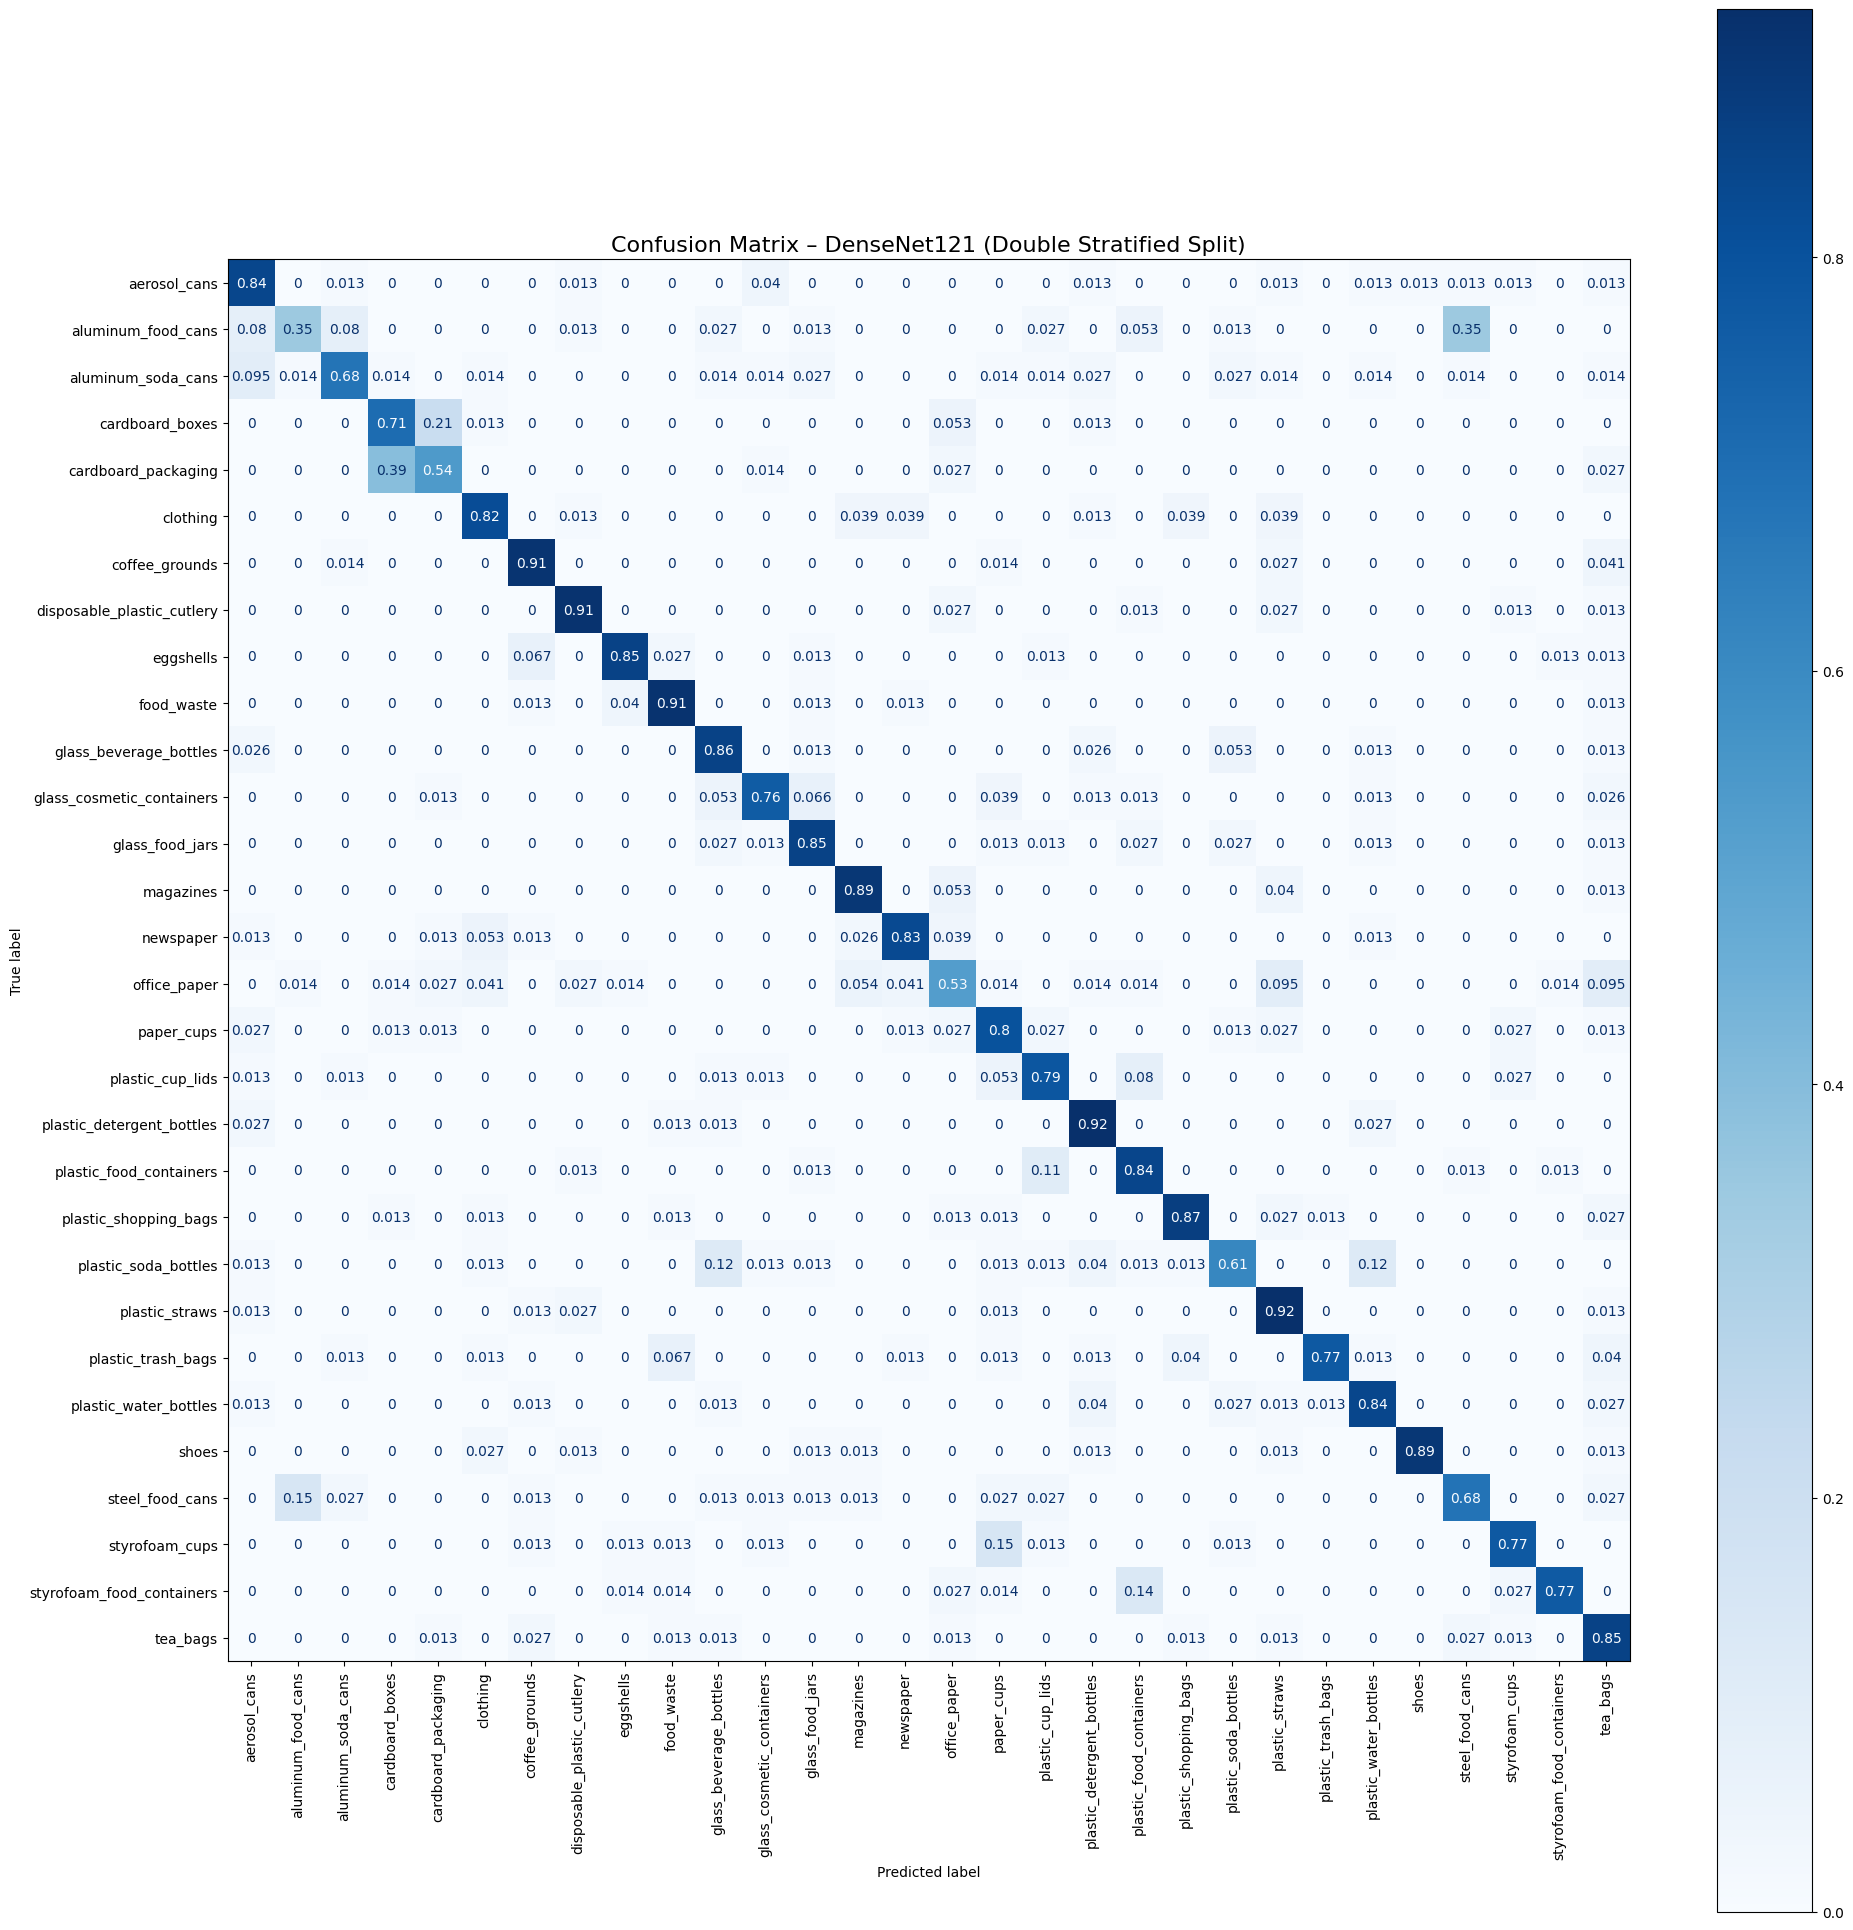


🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 84.00%
aluminum_food_cans             — Accuracy: 34.67%
aluminum_soda_cans             — Accuracy: 67.57%
cardboard_boxes                — Accuracy: 70.67%
cardboard_packaging            — Accuracy: 54.05%
clothing                       — Accuracy: 81.58%
coffee_grounds                 — Accuracy: 90.54%
disposable_plastic_cutlery     — Accuracy: 90.67%
eggshells                      — Accuracy: 85.33%
food_waste                     — Accuracy: 90.67%
glass_beverage_bottles         — Accuracy: 85.53%
glass_cosmetic_containers      — Accuracy: 76.32%
glass_food_jars                — Accuracy: 85.33%
magazines                      — Accuracy: 89.33%
newspaper                      — Accuracy: 82.89%
office_paper                   — Accuracy: 52.70%
paper_cups                     — Accuracy: 80.00%
plastic_cup_lids               — Accuracy: 78.67%
plastic_detergent_bottles 

In [32]:
# ----------------------
# BLOCK 2: ACCURACY BREAKDOWN (DenseNet121 Double Stratified)
# ----------------------

densenet_class_correct = [0] * num_classes
densenet_class_total = [0] * num_classes
densenet_default_correct = 0
densenet_default_total = 0
densenet_real_correct = 0
densenet_real_total = 0
densenet_all_preds = []
densenet_all_labels = []

model_densenet.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader_densenet):
        images, labels = images.to(device), labels.to(device)
        outputs = model_densenet(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true = labels[j].item()
            pred = predicted[j].item()
            densenet_class_total[true] += 1
            if true == pred:
                densenet_class_correct[true] += 1

            path = test_paths_densenet[i * test_loader_densenet.batch_size + j]
            if "default" in path:
                densenet_default_total += 1
                if true == pred:
                    densenet_default_correct += 1
            elif "real_world" in path:
                densenet_real_total += 1
                if true == pred:
                    densenet_real_correct += 1

            densenet_all_preds.append(pred)
            densenet_all_labels.append(true)

# ----------------------
# CONFUSION MATRIX (Normalized)
# ----------------------
cm_densenet = confusion_matrix(densenet_all_labels, densenet_all_preds, normalize='true')
disp_densenet = ConfusionMatrixDisplay(confusion_matrix=cm_densenet, display_labels=full_dataset_val_densenet.classes)

fig, ax = plt.subplots(figsize=(20, 20))
disp_densenet.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
ax.set_xticklabels(full_dataset_val_densenet.classes, fontsize=10, rotation=90)
ax.set_yticklabels(full_dataset_val_densenet.classes, fontsize=10)
plt.title("Confusion Matrix – DenseNet121 (Double Stratified Split)", fontsize=16)
plt.tight_layout()
plt.show()

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-" * 40)
for i, class_name in enumerate(full_dataset_val_densenet.classes):
    acc = 100 * densenet_class_correct[i] / densenet_class_total[i] if densenet_class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# DEFAULT vs REAL-WORLD ACCURACY
# ----------------------
densenet_default_acc = 100 * densenet_default_correct / densenet_default_total if densenet_default_total > 0 else 0.0
densenet_real_acc = 100 * densenet_real_correct / densenet_real_total if densenet_real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type:\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {densenet_default_acc:.2f}% ({densenet_default_correct}/{densenet_default_total})")
print(f"Real-World Photos   — Accuracy: {densenet_real_acc:.2f}% ({densenet_real_correct}/{densenet_real_total})")

# ----------------------
# OVERALL ACCURACY
# ----------------------
densenet_overall_acc = 100 * sum(densenet_class_correct) / sum(densenet_class_total)
print(f"\n✅ Overall Test Accuracy (Double Stratified - DenseNet121): {densenet_overall_acc:.2f}%")


# MODEL 10: First Attempt w/ Pre-trained ViT_B_16 (Not traditional CNN)

Using device: cpu


/Users/lukestockbridge/miniconda3/envs/nn/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lukestockbridge/miniconda3/envs/nn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /Users/lukestockbridge/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|████████████████████████████████████████| 330M/330M [00:38<00:00, 8.93MB/s]
                                                                                

Epoch 1 | Train Loss: 1.0947 | Val Loss: 0.6018


Epoch 2 | Train Loss: 0.5764 | Val Loss: 0.5017


Epoch 3 | Train Loss: 0.4571 | Val Loss: 0.4752


Epoch 4 | Train Loss: 0.3973 | Val Loss: 0.4657


Epoch 5 | Train Loss: 0.3448 | Val Loss: 0.4522


Epoch 6 | Train Loss: 0.3161 | Val Loss: 0.4699


Epoch 7 | Train Loss: 0.2887 | Val Loss: 0.4442


Epoch 8 | Train Loss: 0.2725 | Val Loss: 0.4579


Epoch 9 | Train Loss: 0.2383 | Val Loss: 0.4558


Epoch 10 | Train Loss: 0.2312 | Val Loss: 0.4686
Early stopping triggered after 10 epochs.


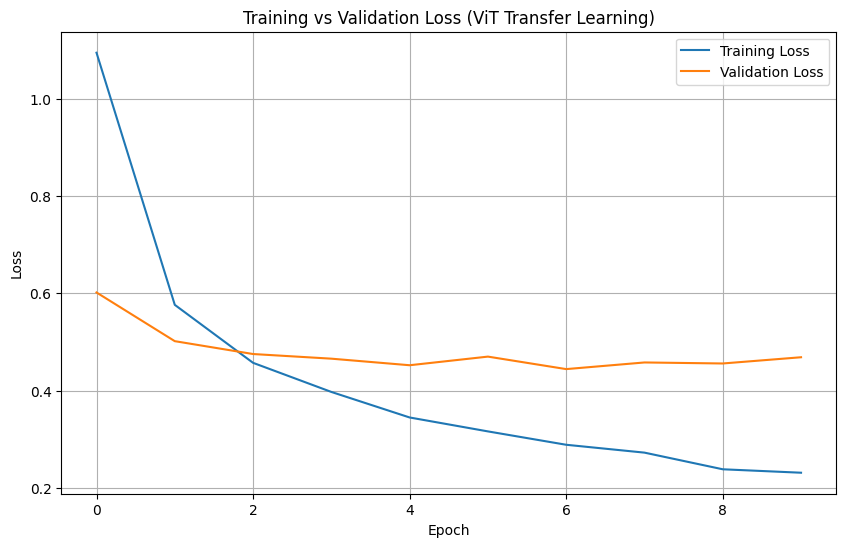

In [33]:
# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# TRANSFORMS (ViT expects 224x224 and ImageNet normalization)
# ----------------------
transform_train_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----------------------
# LOAD DATASETS AND SPLITS
# ----------------------
full_dataset_train_vit = ImageFolder("images/", transform=transform_train_vit)
full_dataset_val_vit = ImageFolder("images/", transform=transform_val_vit)

train_loader_vit = DataLoader(Subset(full_dataset_train_vit, double_strat_train_dataset.indices), batch_size=32, shuffle=True)
val_loader_vit = DataLoader(Subset(full_dataset_val_vit, double_strat_val_dataset.indices), batch_size=32, shuffle=False)
test_loader_vit = DataLoader(Subset(full_dataset_val_vit, double_strat_test_dataset.indices), batch_size=32, shuffle=False)
test_paths_vit = [full_dataset_val_vit.samples[i][0] for i in double_strat_test_dataset.indices]

# ----------------------
# MODEL SETUP (ViT)
# ----------------------
num_classes = len(full_dataset_train_vit.classes)
model_vit = models.vit_b_16(pretrained=True)

# Freeze all layers
for param in model_vit.parameters():
    param.requires_grad = False

# Replace classifier head
model_vit.heads = nn.Sequential(
    nn.Linear(model_vit.heads.head.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

model_vit = model_vit.to(device)

# ----------------------
# LOSS, OPTIMIZER, TRAINING CONFIG
# ----------------------
criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(model_vit.heads.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs_vit = 25
patience_vit = 3
best_val_loss_vit = float('inf')
patience_counter_vit = 0
history_vit = {"loss": [], "val_loss": []}

# ----------------------
# TRAINING LOOP
# ----------------------
for epoch in range(num_epochs_vit):
    model_vit.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader_vit, total=len(train_loader_vit), leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vit(images)
        loss = criterion_vit(outputs, labels)

        optimizer_vit.zero_grad()
        loss.backward()
        optimizer_vit.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    train_loss = running_loss / len(train_loader_vit)
    history_vit["loss"].append(train_loss)

    # ----------------------
    # VALIDATION
    # ----------------------
    model_vit.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader_vit:
            images, labels = images.to(device), labels.to(device)
            outputs = model_vit(images)
            loss = criterion_vit(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader_vit)
    history_vit["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss_vit:
        best_val_loss_vit = val_loss
        patience_counter_vit = 0
        torch.save(model_vit.state_dict(), "best_vit_model.pt")
    else:
        patience_counter_vit += 1
        if patience_counter_vit >= patience_vit:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history_vit["loss"], label="Training Loss")
plt.plot(history_vit["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (ViT Transfer Learning)")
plt.legend()
plt.grid(True)
plt.show()


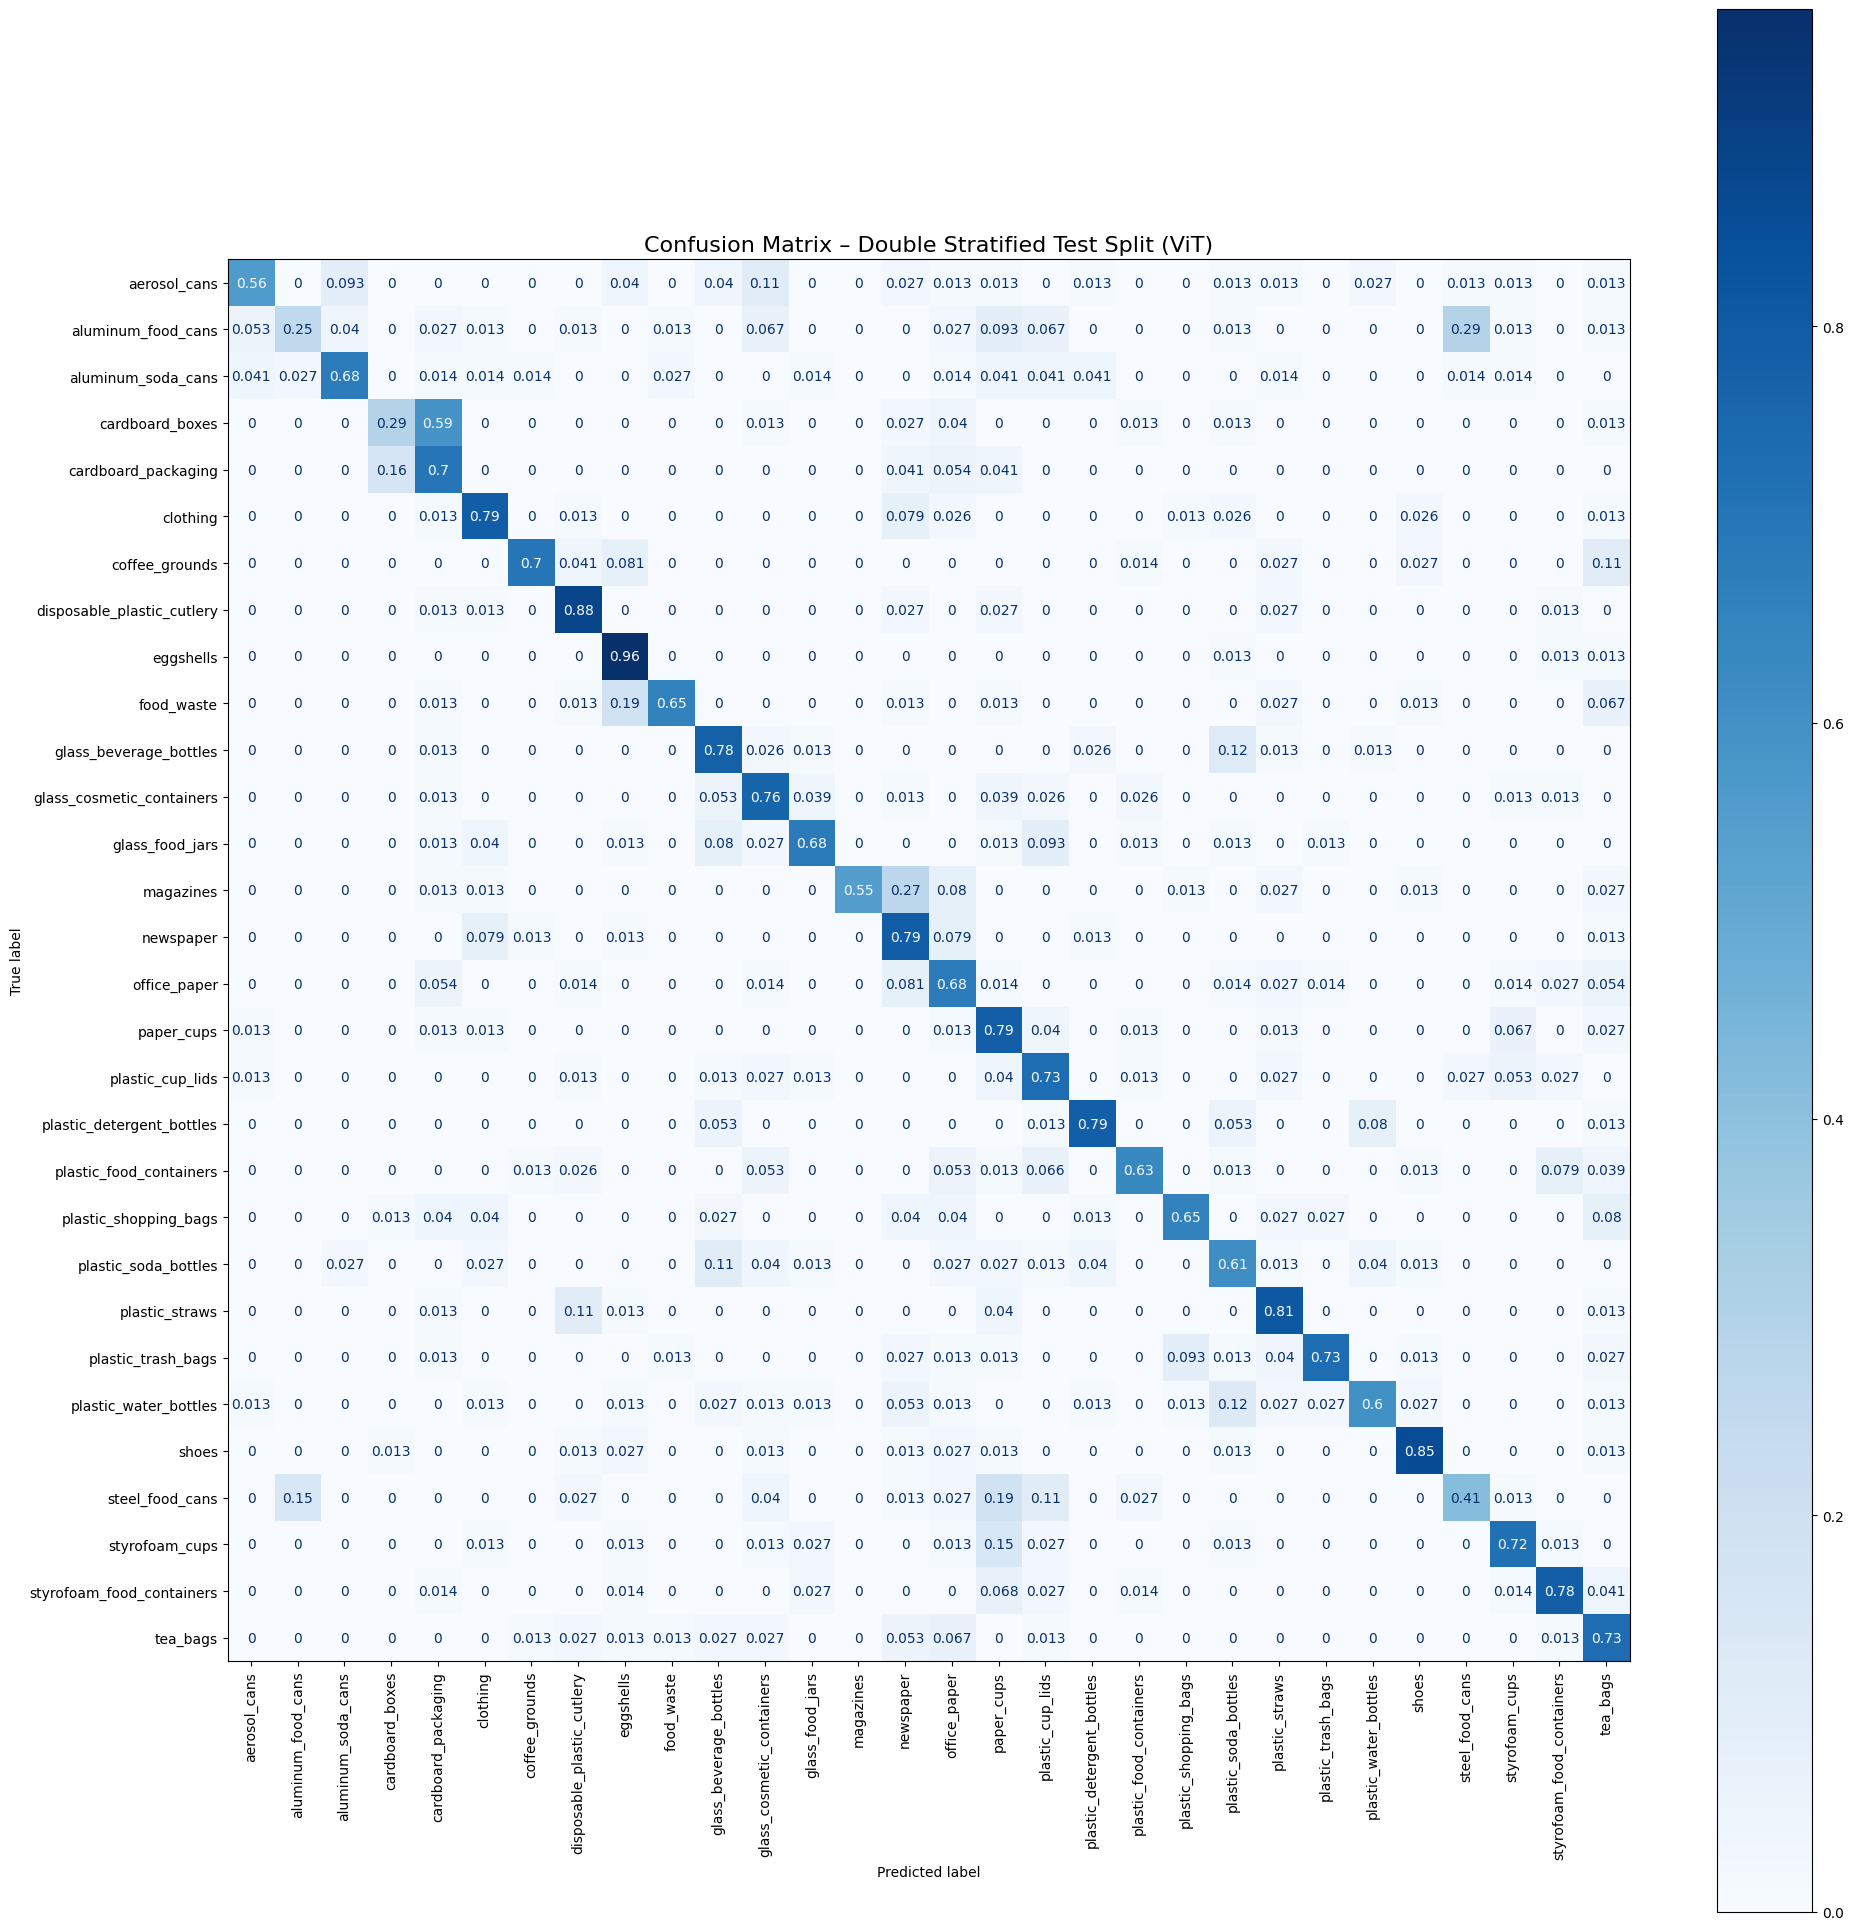


🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 56.00%
aluminum_food_cans             — Accuracy: 25.33%
aluminum_soda_cans             — Accuracy: 67.57%
cardboard_boxes                — Accuracy: 29.33%
cardboard_packaging            — Accuracy: 70.27%
clothing                       — Accuracy: 78.95%
coffee_grounds                 — Accuracy: 70.27%
disposable_plastic_cutlery     — Accuracy: 88.00%
eggshells                      — Accuracy: 96.00%
food_waste                     — Accuracy: 65.33%
glass_beverage_bottles         — Accuracy: 77.63%
glass_cosmetic_containers      — Accuracy: 76.32%
glass_food_jars                — Accuracy: 68.00%
magazines                      — Accuracy: 54.67%
newspaper                      — Accuracy: 78.95%
office_paper                   — Accuracy: 67.57%
paper_cups                     — Accuracy: 78.67%
plastic_cup_lids               — Accuracy: 73.33%
plastic_detergent_bottles 

In [34]:
# ----------------------
# ACCURACY: Per-Class + Real-World vs Default Breakdown (ViT)
# ----------------------
vit_class_correct = [0] * num_classes
vit_class_total = [0] * num_classes
vit_default_correct = 0
vit_default_total = 0
vit_real_correct = 0
vit_real_total = 0
vit_all_preds = []
vit_all_labels = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j].item()
            pred_label = predicted[j].item()
            vit_class_total[true_label] += 1
            if true_label == pred_label:
                vit_class_correct[true_label] += 1

            path = test_paths_vit[i * test_loader.batch_size + j]
            if "default" in path:
                vit_default_total += 1
                if true_label == pred_label:
                    vit_default_correct += 1
            elif "real_world" in path:
                vit_real_total += 1
                if true_label == pred_label:
                    vit_real_correct += 1

            vit_all_preds.append(pred_label)
            vit_all_labels.append(true_label)

# ----------------------
# CONFUSION MATRIX (Normalized)
# ----------------------
vit_cm = confusion_matrix(vit_all_labels, vit_all_preds, normalize='true')
vit_disp = ConfusionMatrixDisplay(confusion_matrix=vit_cm, display_labels=full_dataset_val.classes)

fig, ax = plt.subplots(figsize=(20, 20))
vit_disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
ax.set_xticklabels(full_dataset_val.classes, fontsize=10, rotation=90)
ax.set_yticklabels(full_dataset_val.classes, fontsize=10)
plt.title("Confusion Matrix – Double Stratified Test Split (ViT)", fontsize=16)
plt.tight_layout()
plt.show()

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-" * 40)
for i, class_name in enumerate(full_dataset_val.classes):
    acc = 100 * vit_class_correct[i] / vit_class_total[i] if vit_class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# DEFAULT vs REAL-WORLD ACCURACY
# ----------------------
vit_default_acc = 100 * vit_default_correct / vit_default_total if vit_default_total > 0 else 0.0
vit_real_acc = 100 * vit_real_correct / vit_real_total if vit_real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type:\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {vit_default_acc:.2f}% ({vit_default_correct}/{vit_default_total})")
print(f"Real-World Photos   — Accuracy: {vit_real_acc:.2f}% ({vit_real_correct}/{vit_real_total})")

# ----------------------
# OVERALL ACCURACY
# ----------------------
vit_overall_acc = 100 * sum(vit_class_correct) / sum(vit_class_total)
print(f"\n✅ Overall Test Accuracy (Double Stratified – ViT): {vit_overall_acc:.2f}%")


## Details: Double Stratified Split

## Build CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
#!pip install tensorflow matplotlib scikit-learn

In [5]:
from torch.utils.data import random_split

# 80-20 split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [6]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Placeholder for fc1 — we'll initialize it after knowing the flatten size
        self._flattened_size = None
        self.fc1 = None
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        # Initialize fc1 if we haven't yet
        if self.fc1 is None:
            self._flattened_size = x.shape[1]
            self.fc1 = nn.Linear(self._flattened_size, 128).to(x.device)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch 1, Loss: 1065.459, Train Accuracy: 20.75%
Epoch 2, Loss: 1026.542, Train Accuracy: 23.36%
Epoch 3, Loss: 1002.822, Train Accuracy: 24.92%
Epoch 4, Loss: 979.822, Train Accuracy: 26.45%
Epoch 5, Loss: 963.695, Train Accuracy: 27.52%
Epoch 6, Loss: 945.578, Train Accuracy: 28.23%
Epoch 7, Loss: 928.535, Train Accuracy: 30.22%


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.20      0.09      0.12       110
        aluminum_food_cans       0.26      0.16      0.19       116
        aluminum_soda_cans       0.29      0.21      0.25       103
           cardboard_boxes       0.38      0.56      0.45       113
       cardboard_packaging       0.33      0.18      0.23       106
                  clothing       0.35      0.30      0.32       105
            coffee_grounds       0.52      0.80      0.63        85
disposable_plastic_cutlery       0.34      0.17      0.23        94
                 eggshells       0.29      0.23      0.26       100
                food_waste       0.33      0.62      0.43        99
    glass_beverage_bottles       0.34      0.43      0.38       102
 glass_cosmetic_containers       0.24      0.33      0.28        99
           glass_food_jars       0.38      0.37      0.38       100
                 magazin